In [2]:
from __future__ import print_function

import math
import numpy as np
import os
import sys
import fnmatch
import scipy.optimize as op
from astropy.io import fits
from astropy.table import Table, Column, MaskedColumn,unique
from astropy.io import ascii
from astropy.table import QTable,vstack
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib
from astropy import units as u
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import PercentFormatter
import matplotlib.patches as mpatches

from mpl_toolkits.axes_grid1 import make_axes_locatable
from linetools.spectra.xspectrum1d import XSpectrum1D
import model_NaI
import model_fitter
import continuum_normalize_NaI
#import NaImcmc_read_fits
#import NaImcmc_fitwrapper
#import ew_NaI_allspax
import pdb
import corner 
import glob
import os
from kcwi_jnb import cube
from kcwi_jnb import transform
from scipy import stats

plt.rcParams['figure.figsize'] = (10,8)
plt.rc('axes', labelsize = 16)
plt.rc('axes', titlesize = 18)
#pl.rc('axes', titleweight = 'bold')
plt.rc('axes', lw = 1)
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.minor.size'] = 4
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3

import numpy as np
import numpy.ma as ma
import pandas as pd
import scipy.stats as st
import numba

import emcee
import ptemcee

import bebi103

import extinction
import bokeh.io
import bokeh.plotting
from bokeh.models import ColumnDataSource, CustomJS, Slider,Div,SingleIntervalTicker,ColorBar
bokeh.io.output_notebook()
from linetools.analysis import voigt as lav
from scipy.optimize import curve_fit

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/bebi103/viz.py:38: UserWarning: DataShader import failed with error "No module named 'datashader'".
Features requiring DataShader will not work and you will get exceptions.
  warnings.warn(
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BokehJS ...

In [3]:
# directory path for NGC 4030 and NGC 1042
path = '/Users/erickaguirre/Desktop/DAP_outputs/'
bin_dir1 = 'output0.6_'
bin_dir2 = 'output1.0_'
bin_dir3 = 'output2.0_'
#bin_dir = 'output2.0_'
gal_name = 'NGC4030'
#gal_name = 'NGC1042'
#gal_sub_dir = '/SQUARE2.0-MILESHC-MASTARSSP/1/2/'
gal_sub_dir1 = '/SQUARE0.6-MILESHC-MASTARSSP/1/1/'
gal_sub_dir2 = '/SQUARE1.0-MILESHC-MASTARSSP/1/1/'
gal_sub_dir3 = '/SQUARE2.0-MILESHC-MASTARSSP/1/1/'
#gal_sub_dir = '/SQUARE0.6-MILESHC-MASTARSSP/1/1/'
#gal_sub_dir = '/SQUARE2.0-MILESHC-MASTARSSP/1/1/'

# For continuum-normalization around NaI
# wavelength continuum fitting range outside of NaI region
blim = [5850.0,5870.0]
rlim = [5910.0,5930.0]
# wavelength fitting range inside of NaI region
fitlim = [5880.0,5910.0]
# speed of light in km/s
c = 2.998e5
# Na I doublet vacuum absorption wavelengths 
D1 = 5891.582 # in angstroms
D2 = 5897.558 # in angstroms
redshift = 0.00489 

# log cube model and data file path
log_cube_file1 = path + bin_dir1 + gal_name + gal_sub_dir1 + 'manga-1-1-LOGCUBE-SQUARE0.6-MILESHC-MASTARSSP.fits'
log_cube_file2 = path + bin_dir2 + gal_name + gal_sub_dir2 + 'manga-1-1-LOGCUBE-SQUARE1.0-MILESHC-MASTARSSP.fits'
log_cube_file3 = path + bin_dir3 + gal_name + gal_sub_dir3 + 'manga-1-1-LOGCUBE-SQUARE2.0-MILESHC-MASTARSSP.fits'
#log_cube_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-2-LOGCUBE-SQUARE2.0-MILESHC-MASTARSSP.fits'
log_cube1 = fits.open(log_cube_file1)
log_cube2 = fits.open(log_cube_file2)
log_cube3 = fits.open(log_cube_file3)
# log maps file path
log_maps_file1 = path + bin_dir1 + gal_name + gal_sub_dir1 + 'manga-1-1-MAPS-SQUARE0.6-MILESHC-MASTARSSP.fits.gz'
log_maps_file2 = path + bin_dir2 + gal_name + gal_sub_dir2 + 'manga-1-1-MAPS-SQUARE1.0-MILESHC-MASTARSSP.fits.gz'
log_maps_file3 = path + bin_dir3 + gal_name + gal_sub_dir3 + 'manga-1-1-MAPS-SQUARE2.0-MILESHC-MASTARSSP.fits.gz'
#log_maps_fil = path + bin_dir + gal_name + gal_sub_dir + 'manga-1-2-MAPS-SQUARE2.0-MILESHC-MASTARSSP.fits.gz'
# log maps file 
hdu_map1 = fits.open(log_maps_file1)
hdu_map2 = fits.open(log_maps_file2)
hdu_map3 = fits.open(log_maps_file3)
# bin ID has multiple layers of the same bin id map so use first one
binid_map1 = hdu_map1['BINID'].data[0]
binid_map2 = hdu_map2['BINID'].data[0]
binid_map3 = hdu_map3['BINID'].data[0]
# stellar velocity map
ppxf_v_map1 = hdu_map1['STELLAR_VEL'].data
ppxf_v_map2 = hdu_map2['STELLAR_VEL'].data
ppxf_v_map3 = hdu_map3['STELLAR_VEL'].data
#SNR map
SNR_map1 = hdu_map1['BIN_SNR'].data
SNR_map2 = hdu_map2['BIN_SNR'].data
SNR_map3 = hdu_map3['BIN_SNR'].data

# obtain flux array from MUSE cube
spec1 = log_cube1['FLUX'].data
spec2 = log_cube2['FLUX'].data
spec3 = log_cube3['FLUX'].data
mod1 = log_cube1['MODEL'].data
mod2 = log_cube2['MODEL'].data
mod3 = log_cube3['MODEL'].data
ivar1 = log_cube1['IVAR'].data
ivar2 = log_cube2['IVAR'].data
ivar3 = log_cube3['IVAR'].data
espec1 = np.sqrt(1/ivar1)
espec2 = np.sqrt(1/ivar2)
espec3 = np.sqrt(1/ivar3)
wave1 =log_cube1['WAVE'].data
wave2 =log_cube2['WAVE'].data
wave3 =log_cube3['WAVE'].data

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2008923485.py:69: RuntimeWarning: divide by zero encountered in divide
  espec1 = np.sqrt(1/ivar1)
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2008923485.py:70: RuntimeWarning: divide by zero encountered in divide
  espec2 = np.sqrt(1/ivar2)
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2008923485.py:71: RuntimeWarning: divide by zero encountered in divide
  espec3 = np.sqrt(1/ivar3)


In [42]:
spec1.shape

(4009, 326, 326)

In [4]:
segment = (np.max(wave1)-np.min(wave1))/10

chunk = np.arange(np.min(wave1),np.max(wave1)+segment,segment)
print(segment)

460.20205078125


In [5]:
def beta_func_quad(N_spx,a,b):
    return 1 + a*(np.log10(N_spx))**b

In [12]:
def get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,mod1,mod2,mod3,
            espec1,espec2,espec3,wv_lim,key,mask_key=None,mask_lims=None):
    
    bin_size1 = []
    bin_size2 = []
    bin_size3 = []
    
    SNR1 = []
    SNR2 = []
    SNR3 = []

    beta1_b = []
    beta2_b = []
    beta3_b = []
    
    # select wavelength range
    spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
    mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
    espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
    wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
    
    for i in range(np.max(binid_map1)+1):
        id_mask1 = binid_map1 == i
        # get bin sizes and SNR for each bin id
        bin_size1.append( len(spec_filt1[:,id_mask1][0,:]) )
        # get flux, stellar continuum model and variance array from bin id
        flux1 = spec_filt1[:,id_mask1][:,0]
        model1 = mod_filt1[:,id_mask1][:,0]
        error1 = espec_filt1[:,id_mask1][:,0]
        
        # mask unaccounted emission or absorption lines if present in spectrum
        if mask_key == True:
            flux1_mask = np.zeros(len(flux1))
            model1_mask = np.zeros(len(model1))
            error1_mask = np.zeros(len(error1))

            for mask_lim in mask_lims:
                for i in range(len(flux1)):
                    if (wave_filt1[i] >= mask_lim[0]) & (wave_filt1[i] <= mask_lim[1]):
                        flux1_mask[i] = 1
                        model1_mask[i] = 1
                        error1_mask[i] = 1

            flux1_ma = ma.masked_array(flux1,mask=flux1_mask)
            model1_ma = ma.masked_array(model1,mask=model1_mask)
            error1_ma = ma.masked_array(error1,mask=error1_mask)

            SNR1.append( np.median(flux1_ma/error1_ma) )
            rms1 = np.sqrt( np.mean( (flux1_ma - model1_ma)**2 ) )
            beta1_b.append(rms1/np.median(error1_ma))
            
        else:
            
            SNR1.append(np.median(flux1/error1))
            # get rms between flux and model
            rms1 = np.sqrt( np.mean( (flux1 - model1)**2 ) )
            # caclulate beta value (rN/N)
            beta1_b.append(rms1/np.median(error1))

    bin_size1 = np.array(bin_size1)
    SNR1 = np.array(SNR1)
    beta1_b = np.array(beta1_b)
    
    # select wavelength range
    spec_filt2 = spec2[(wave2 >  wv_lim[0]) & (wave2 <  wv_lim[1])]
    mod_filt2 = mod2[(wave2 >  wv_lim[0]) & (wave2 <  wv_lim[1])]
    espec_filt2 = espec2[(wave2 >  wv_lim[0]) & (wave2 <  wv_lim[1])]
    wave_filt2 = wave2[(wave2 >  wv_lim[0]) & (wave2 <  wv_lim[1])]
    
    for i in range(np.max(binid_map2)+1):
        id_mask2 = binid_map2 == i
        bin_size2.append( len(spec_filt2[:,id_mask2][0,:]) )

        flux2 = spec_filt2[:,id_mask2][:,0]
        model2 = mod_filt2[:,id_mask2][:,0]
        error2 = espec_filt2[:,id_mask2][:,0]
        
        # mask unaccounted emission or absorption lines if present in spectrum
        if mask_key == True:
            flux2_mask = np.zeros(len(flux2))
            model2_mask = np.zeros(len(model2))
            error2_mask = np.zeros(len(error2))

            for mask_lim in mask_lims:
                for i in range(len(flux2)):
                    if (wave_filt2[i] >= mask_lim[0]) & (wave_filt2[i] <= mask_lim[1]):
                        flux2_mask[i] = 1
                        model2_mask[i] = 1
                        error2_mask[i] = 1

            flux2_ma = ma.masked_array(flux2,mask=flux2_mask)
            model2_ma = ma.masked_array(model2,mask=model2_mask)
            error2_ma = ma.masked_array(error2,mask=error2_mask)

            SNR2.append( np.median(flux2_ma/error2_ma) )
            rms2 = np.sqrt( np.mean( (flux2_ma - model2_ma)**2 ) )
            beta2_b.append( rms2/np.median(error2_ma) )
            
        else:

            SNR2.append(np.median(flux2/error2))
            rms2 = np.sqrt( np.mean( (flux2 - model2)**2 ) )
            beta2_b.append(rms2/np.median(error2))


    bin_size2 = np.array(bin_size2)
    SNR2 = np.array(SNR2)
    beta2_b = np.array(beta2_b)

    # select wavelength range
    spec_filt3 = spec3[(wave3 >  wv_lim[0]) & (wave3 <  wv_lim[1])]
    mod_filt3 = mod3[(wave3 >  wv_lim[0]) & (wave3 <  wv_lim[1])]
    espec_filt3 = espec3[(wave3 >  wv_lim[0]) & (wave3 <  wv_lim[1])]
    wave_filt3 = wave3[(wave3 >  wv_lim[0]) & (wave3 <  wv_lim[1])]
    
    for i in range(np.max(binid_map3)+1):
        id_mask3 = binid_map3 == i
        bin_size3.append( len(spec_filt3[:,id_mask3][0,:]) )

        flux3 = spec_filt3[:,id_mask3][:,0]
        model3 = mod_filt3[:,id_mask3][:,0]
        error3 = espec_filt3[:,id_mask3][:,0]
        
        # mask unaccounted emission or absorption lines if present in spectrum
        if mask_key == True:
            flux3_mask = np.zeros(len(flux3))
            model3_mask = np.zeros(len(model3))
            error3_mask = np.zeros(len(error3))

            for mask_lim in mask_lims:
                for i in range(len(flux3)):
                    if (wave_filt3[i] >=mask_lim[0]) & (wave_filt3[i] <=mask_lim[1]):
                        flux3_mask[i] = 1
                        model3_mask[i] = 1
                        error3_mask[i] = 1

            flux3_ma = ma.masked_array(flux3,mask=flux3_mask)
            model3_ma = ma.masked_array(model3,mask=model3_mask)
            error3_ma = ma.masked_array(error3,mask=error3_mask)

            SNR3.append( np.median(flux3_ma/error3_ma) )
            rms3 = np.sqrt( np.mean( (flux3_ma - model3_ma)**2 ) )
            beta3_b.append( rms3/np.median(error3_ma) )
            
        else:
            SNR3.append(np.median(flux3/error3))
            rms3 = np.sqrt( np.mean( (flux3 - model3)**2 ) )
            beta3_b.append(rms3/np.median(error3))

    bin_size3 = np.array(bin_size3)
    SNR3 = np.array(SNR3)
    beta3_b = np.array(beta3_b)
    
    if key=='indiviual':
        return bin_size1,bin_size2,bin_size3,SNR1,SNR2,SNR3,beta1_b,beta2_b,beta3_b
    
    if key=='all':
        # combine all the bins and beta values into a two large 1D arrays
        # to feed into curvefit
        bin_all = np.concatenate((bin_size1,bin_size2,bin_size3))
        SNR_all = np.concatenate((SNR1,SNR2,SNR3))
        beta_all = np.concatenate((beta1_b,beta2_b,beta3_b))

        # obtain only real values
        bin_allreal = bin_all[np.isfinite(beta_all)]
        bin_sort = np.argsort(bin_allreal)
        bin_sort_real = bin_allreal[bin_sort]

        SNR_allreal = SNR_all[np.isfinite(beta_all)]
        SNR_sort = np.argsort(SNR_allreal)
        SNR_sort_real = SNR_allreal[SNR_sort]

        beta_all_real = beta_all[np.isfinite(beta_all)]
        beta_sort_real = beta_all_real[bin_sort]
        
        return bin_sort_real,SNR_sort_real,beta_sort_real

In [13]:
#wv_lims = [[4900,5100],[5800,6000],[7000,7200],[8000,82000]]
# wv_lims = [[4751.42, 5672],[5672, 6592],[6592,75123],
#             [7513,8433],[8433,9353.44]]
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]


bin_sort_real0,SNR_sort_real0,beta_sort_real0 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[0],key='all')
                                                      

In [14]:
# wv_lims = [[4751.42, 5672],[5672, 6592],[6592,75123],
#             [7513,8433],[8433,9353.44]]
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

# mask emission and absorption lines model does not include
mask_lims = [[5575,5583]]
bin_sort_real1,SNR_sort_real1,beta_sort_real1 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[1],key='all',
                                                      mask_key=True,mask_lims=mask_lims)

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [15]:
# wv_lims = [[4751.42, 5672],[5672, 6592],[6592,75123],
#             [7513,8433],[8433,9353.44]]
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real2,SNR_sort_real2,beta_sort_real2 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[2],key='all')

In [16]:
# wv_lims = [[4751.42, 5672],[5672, 6592],[6592,75123],
#             [7513,8433],[8433,9353.44]]
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

# mask emission and absorption lines model does not include
mask_lims = [[6296,6308],[6361,6371]]
bin_sort_real3,SNR_sort_real3,beta_sort_real3 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[3],key='all',
                                                      mask_key=True,mask_lims=mask_lims)

In [17]:
# wv_lims = [[4751.42, 5672],[5672, 6592],[6592,75123],
#             [7513,8433],[8433,9353.44]]
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real4,SNR_sort_real4,beta_sort_real4 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[4],key='all')

In [18]:
# wv_lims = [[4751.42, 5672],[5672, 6592],[6592,75123],
#             [7513,8433],[8433,9353.44]]
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real5,SNR_sort_real5,beta_sort_real5 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[5],key='all')

In [19]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real6,SNR_sort_real6,beta_sort_real6 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[6],key='all')

In [20]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real7,SNR_sort_real7,beta_sort_real7 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[7],key='all')

In [21]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real8,SNR_sort_real8,beta_sort_real8 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[8],key='all')

In [22]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

bin_sort_real9,SNR_sort_real9,beta_sort_real9 = get_beta(binid_map1,binid_map2,binid_map3,spec1,spec2,spec3,
                                                      mod1,mod2,mod3, espec1,espec2,espec3,
                                                      wv_lim=wv_lims[9],key='all')

Model Fit (4900-5100 A): beta = 1 + 1.65 log10(N_spaxels)^1.30
Model Fit (5800-6000 A): beta = 1 + 1.69 log10(N_spaxels)^1.33
Model Fit (7000-7200 A): beta = 1 + 0.45 log10(N_spaxels)^1.58


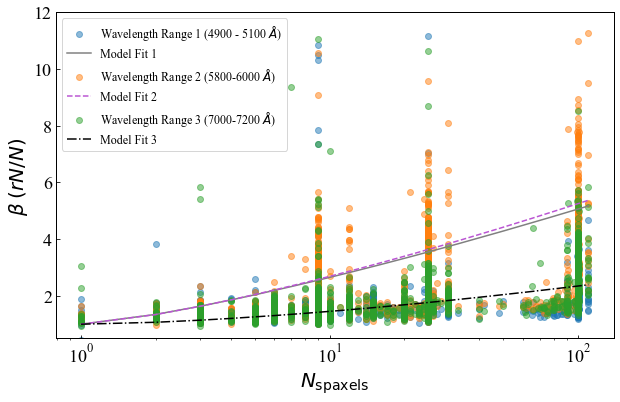

In [62]:
pl.scatter(bin_sort_real0,beta_sort_real0,alpha=0.5,
           label=r'Wavelength Range 1 ({} - {} $\AA$)'.format(wv_lims[0][0],wv_lims[0][1]))
pl.plot(bin_sort_real0, beta_func_quad(bin_sort_real0,*popt0),
         c='grey',ls='-',label='Model Fit 1')

pl.scatter(bin_sort_real1,beta_sort_real1,alpha=0.5,
           label=r'Wavelength Range 2 ({}-{} $\AA$)'.format(wv_lims[1][0],wv_lims[1][1]))
pl.plot(bin_sort_real1, beta_func_quad(bin_sort_real1,*popt1),
         c='mediumorchid',ls='--',label='Model Fit 2')

pl.scatter(bin_sort_real2,beta_sort_real2,alpha=0.5,
           label=r'Wavelength Range 3 ({}-{} $\AA$)'.format(wv_lims[2][0],wv_lims[2][1]))
pl.plot(bin_sort_real2, beta_func_quad(bin_sort_real2,*popt2),
         c='k',ls='-.',label='Model Fit 3')

# pl.scatter(bin_sort_real3,beta_sort_real3,alpha=0.5,
#            label=r'Wavelength Range 4 ({}-{} $\AA$)'.format(wv_lims[3][0],wv_lims[3][1]))
# pl.plot(bin_sort_real3, beta_func_quad(bin_sort_real3,*popt1),
#          c='cyan',ls=':',label='Model Fit 4')


# reordering the labels
handles, labels = pl.gca().get_legend_handles_labels()  
# specify order
#order = [4,0,5,1,6,2,7,3]
order = [3,0,4,1,5,2]
# pass handle & labels lists along with order as below
pl.legend([handles[i] for i in order], [labels[i] for i in order],fontsize='large')
pl.ylim(0.5,12)
pl.xscale('log')

pl.tick_params(axis='both',direction='in')
pl.ylabel(r'$\beta$ $(rN/N)$')
pl.xlabel(r'$N_{\mathrm{spaxels}}$');

print('Model Fit ({}-{} A): beta = 1 + {:.2f} log10(N_spaxels)^{:.2f}'.format(wv_lims[0][0],wv_lims[0][1],
                                                                              popt0[0],popt0[1]))
print('Model Fit ({}-{} A): beta = 1 + {:.2f} log10(N_spaxels)^{:.2f}'.format(wv_lims[1][0],wv_lims[1][1],
                                                                              popt1[0],popt1[1]))
print('Model Fit ({}-{} A): beta = 1 + {:.2f} log10(N_spaxels)^{:.2f}'.format(wv_lims[2][0],wv_lims[2][1],
                                                                              popt2[0],popt2[1]))
# print('Model Fit ({}-{} A): beta = 1 + {:.2f} log10(N_spaxels)^{:.2f}'.format(wv_lims[3][0],wv_lims[3][1],
#                                                                               popt3[0],popt3[1]))

In [23]:
def get_betagood(bins,betas,SNRs,Nspax_range,SNR_ranges):
    
    # exclude outliers
    bin_good = bins[betas < 20]
    SNR_good = SNRs[betas < 20]
    beta_good = betas[betas < 20]
    
    # filter arrays given spaxel size range
    bin_filt = bin_good[(bin_good > Nspax_range[0]) & (bin_good < Nspax_range[1])]
    beta = beta_good[(bin_good > Nspax_range[0]) & (bin_good < Nspax_range[1])]
    SNR = SNR_good[(bin_good > Nspax_range[0]) & (bin_good < Nspax_range[1])]
    
    # filter arrays given S/N range
    bin_less50 = bin_filt[(SNR > SNR_ranges[0][0]) & (SNR < SNR_ranges[0][1])]
    bin_50_75 = bin_filt[(SNR > SNR_ranges[1][0]) & (SNR < SNR_ranges[1][1])]
    bin_75_100 = bin_filt[(SNR > SNR_ranges[2][0]) & (SNR < SNR_ranges[2][1])]
    bin_gr100 = bin_filt[(SNR > SNR_ranges[3][0]) & (SNR < SNR_ranges[3][1])]
    
    beta_less50 = beta[(SNR > SNR_ranges[0][0]) & (SNR < SNR_ranges[0][1])]
    beta_50_75 = beta[(SNR > SNR_ranges[1][0]) & (SNR < SNR_ranges[1][1])]
    beta_75_100 = beta[(SNR > SNR_ranges[2][0]) & (SNR < SNR_ranges[2][1])]
    beta_gr100 = beta[(SNR > SNR_ranges[3][0]) & (SNR < SNR_ranges[3][1])]
    
    bins_SNRs = [bin_less50,bin_50_75,bin_75_100,bin_gr100]
    betas_SNRs = [beta_less50,beta_50_75,beta_75_100,beta_gr100]

    return bins_SNRs,betas_SNRs


# def get_betaplots(bin1,beta1_arr,SNR1,bin2,beta2_arr,SNR2,bin3,beta3_arr,SNR3):
def get_betaplots(bin2,beta2_arr,SNR2,wv_lim):
    
    Nspax_ranges = [[0,5.5],[5.5,20],[20,50],[50,120]]
    SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]
    beta_bins = np.arange(0,15,0.2)
    
    plt.rcParams['figure.figsize'] = (16,12) 
    fig, ((ax1, ax2),(ax3,ax4)) = plt.subplots(2, 2)
    fig.tight_layout(pad=5.0)
    
    bin_tot = []
    beta_tot = []

    for ax,Nspax_range in zip(fig.get_axes(),Nspax_ranges):
        
        bins, betas = get_betagood(bin2,beta2_arr,SNR2,Nspax_range,SNR_ranges)
            
        bin_tot.append(bins)
        beta_tot.append(betas)
        
#         ax.hist(beta1_less100,bins=50,label=r'Range 1 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[0][0],
#                 wv_lims[0][1]),histtype='step',stacked=False,alpha=0.9,fill=False,color='tab:blue')
#         ax.hist(beta1_more100,bins=50,label=r'Range 1 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[0][0],
#                 wv_lims[0][1]),histtype='step',stacked=False,alpha=0.9,fill=False,ls='--',color='tab:blue') 
        
        for i in range(len(SNR_ranges)):
            ax.hist(betas[i],bins=beta_bins,label=r'({} < SNR < {})'.format(
                SNR_ranges[i][0],SNR_ranges[i][1]),histtype='step',
                stacked=False,alpha=0.9,fill=False)
            ax.tick_params(axis='both', which='both', direction='in',top=True,right=True,length=5)
            ax.set_xticks(np.arange(1,10))
        
        colors = ['tab:blue','tab:orange','tab:green','tab:red']
        for beta,color,bin_SNR in zip(betas,colors,bins):
            if np.isnan(np.median(beta)) == True:
                continue
            else:
                ax.axvline(np.median(beta),ls='--',c=color,lw=1)
        
#         ax.hist(beta3_less100,bins=50,label=r'Range 3 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[2][0],
#                 wv_lims[2][1]),histtype='step',stacked=False,alpha=0.9,fill=False,color='tab:gray') 
#         ax.hist(beta3_more100,bins=50,label=r'Range 3 (SNR < {}) ({}-{}$\AA$)'.format(snr_lim,wv_lims[2][0],
#                 wv_lims[2][1]),histtype='step',stacked=False,alpha=0.9,fill=False,ls='-.',color='tab:gray') 
                                               
#         ax.hist(beta2,bins=50,label=r'Range 2 ({}-{}$\AA$)'.format(wv_lims[1][0],wv_lims[1][1]),
#                                                       histtype='step',stacked=False,alpha=0.9,fill=False)
#         ax.hist(beta3,bins=50,label=r'Range 3 ({}-{}$\AA$)'.format(wv_lims[2][0],wv_lims[2][1]),
#                                                       histtype='step',stacked=False,alpha=0.9,fill=False)
        
        ax.set_xlim(0,10)
        ax.set_xlabel(r'$\beta$ (rN/N)')
        ax.set_ylabel('Counts')
        ax.set_title(r'{0} < $N_{{\mathrm{{spax}}}}$ < {1}'.format(Nspax_range[0],Nspax_range[1]))
    
    ax1.set_title(r'$N_{{ \mathrm{{spax}} }}$ < {0}'.format(Nspax_ranges[0][1]))
    ax1.legend(fontsize=16)
    ax4.set_title(r'$N_{{ \mathrm{{spax}} }}$ > {0}'.format(Nspax_ranges[3][0]))
    fig.suptitle(r'$\beta$ Histograms for $\lambda$ Range:{}-{} $\AA$'.format(
                    wv_lim[0],wv_lim[1]),fontsize=22)

    fig.savefig('/Users/erickaguirre/Desktop/paper_plots/beta_correction_plots/beta_hist_'
                +str(wv_lim[0])+'_'+str(wv_lim[1])+'.pdf');

    return bin_tot,beta_tot

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 57.60
beta: 1.42


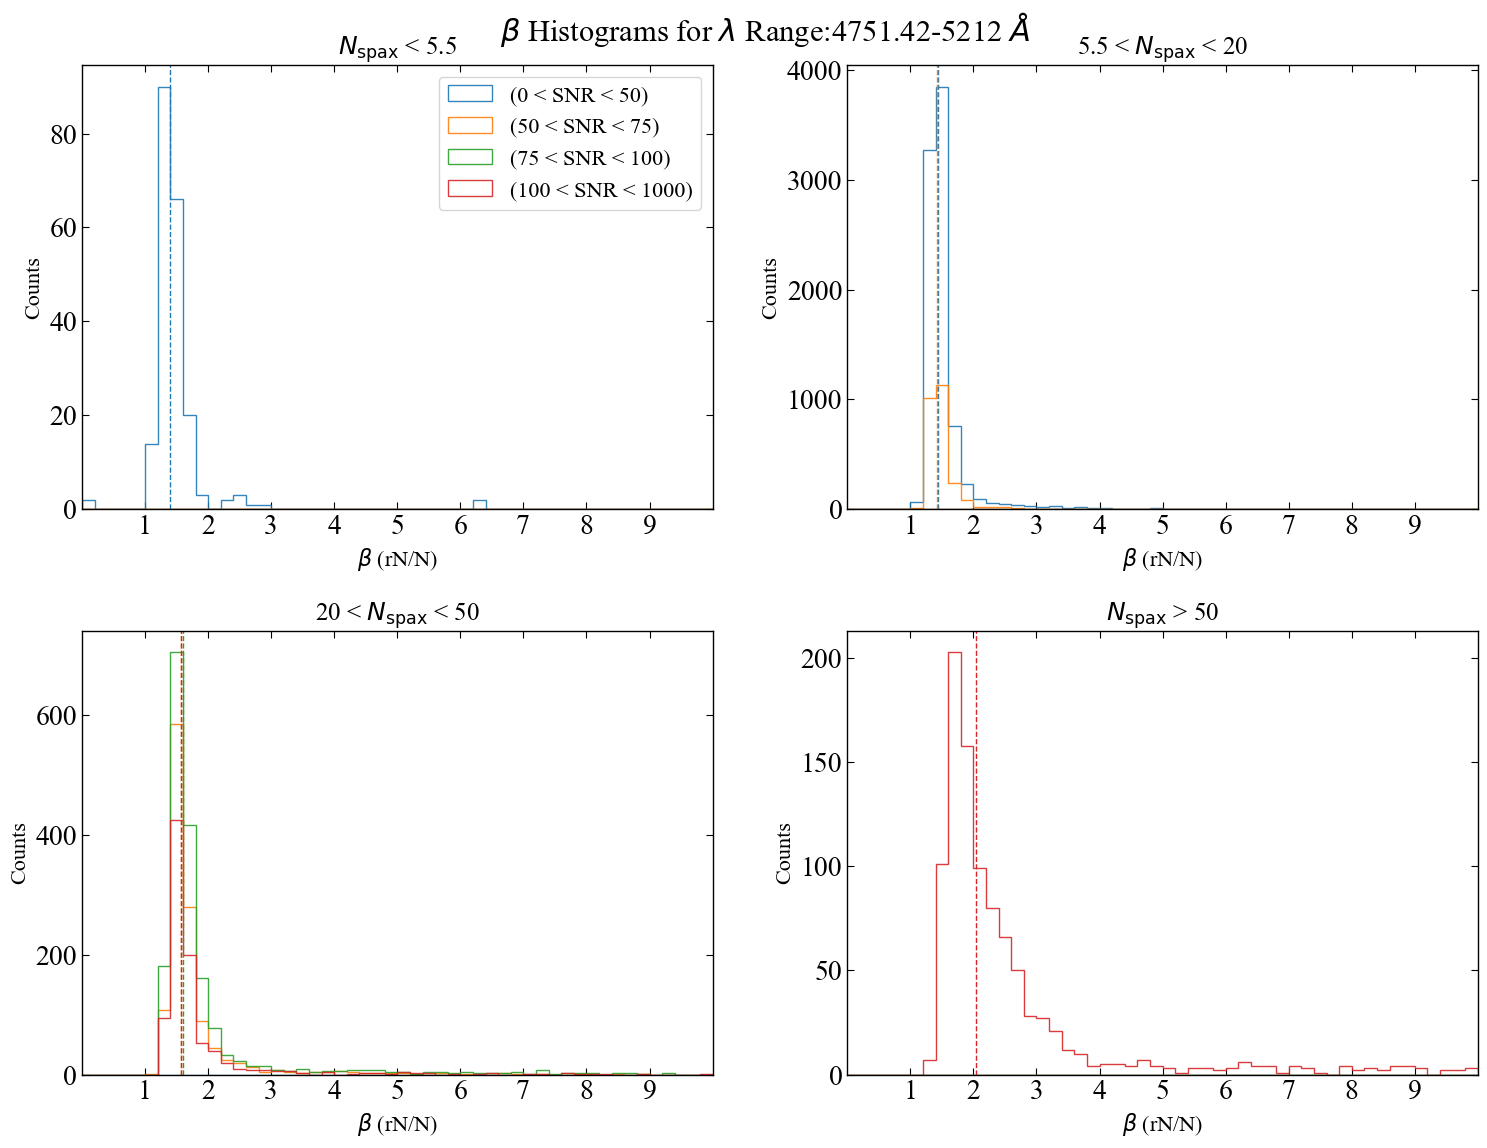

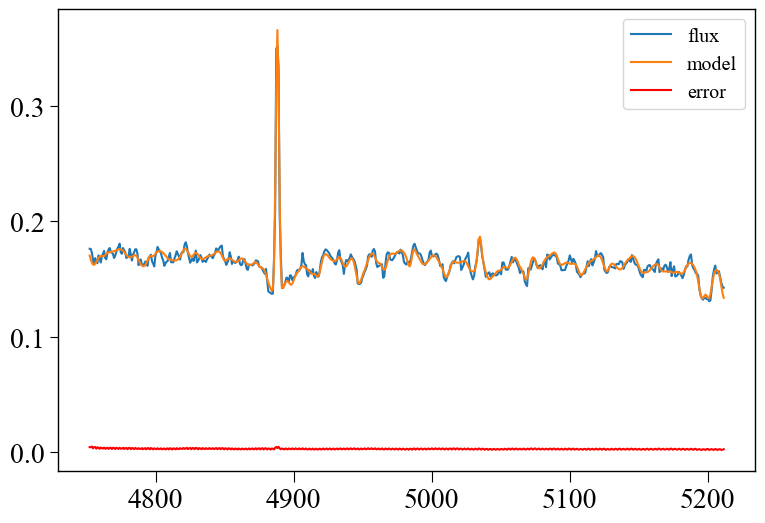

In [24]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot0, beta_tot0 = get_betaplots(bin_sort_real0,beta_sort_real0,SNR_sort_real0,wv_lims[0])

wv_lim = wv_lims[0]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


beta w/ no mask: 4.55
beta w/ mask: 1.42


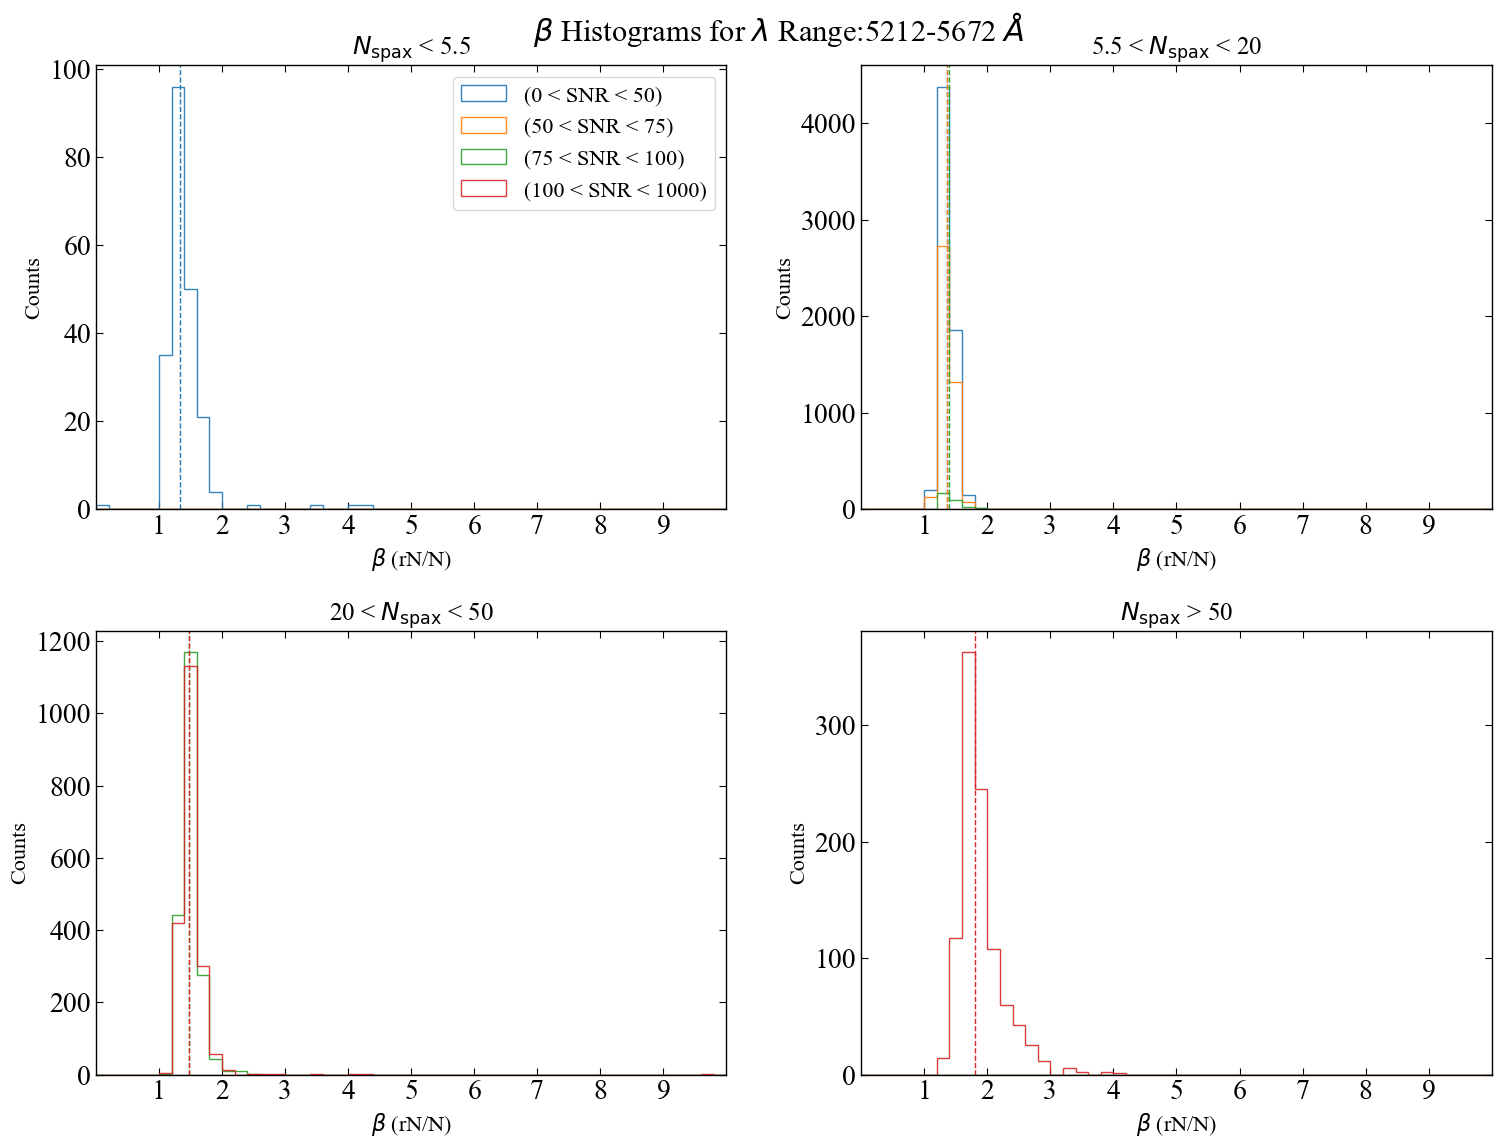

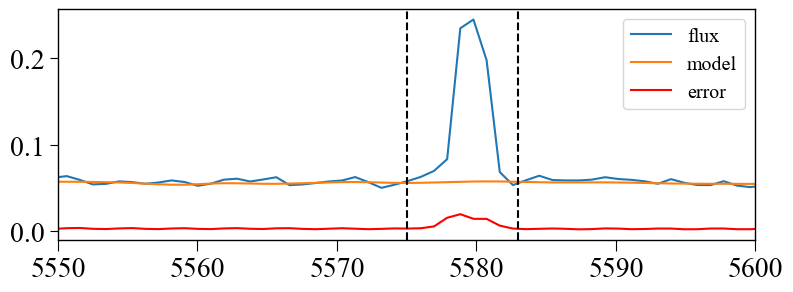

In [25]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot1, beta_tot1 = get_betaplots(bin_sort_real1,beta_sort_real1,SNR_sort_real1,wv_lims[1])

wv_lim = wv_lims[1]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,3))

for i in range(50,51):
    bin_indx = binid_map1 == i
    # get bin sizes and SNR for each bin id
    #bin_size1.append( len(spec1[:,id_mask1][0,:]) )
    # get flux, stellar continuum model and variance array from bin id
#     flux1 = spec_filt1[:,id_mask1][:,0]
#     model1 = mod_filt1[:,id_mask1][:,0]
#     error1 = espec_filt1[:,id_mask1][:,0]
    

#     if mask_key == True:
#         flux1_mask = np.zeros(len(flux1))
#         model1_mask = np.zeros(len(model1))
#         error1_mask = np.zeros(len(error1))
        
#         for mask_lim in mask_lims:
#             for i in range(len(flux1)):
#                 if (wave_filt1[i] >=mask_lim[0]) & (wave_filt1[i] <=mask_lim[1]):
#                     flux1_mask[i] = 1
#                     model1_mask[i] = 1
#                     error1_mask[i] = 1
                    
#         flux1_ma = ma.masked_array(flux1,mask=flux1_mask)
#         model1_ma = ma.masked_array(model1,mask=model1_mask)
#         error1_ma = ma.masked_array(error1,mask=error1_mask)
        
#         S_N = np.median(flux1_ma/error1_ma)
#         rms = np.sqrt( np.mean( (flux1_ma - model1_ma)**2 ) )
#         beta = rms/np.median(error1_ma)
                                    
    plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
    plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
    plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.xlim(5550,5600)
plt.axvline(5575,c='k',ls='--')
plt.axvline(5583,c='k',ls='--')
plt.legend(fontsize='x-large');

S_N_nma = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms_nma = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta_nma = rms_nma/np.median(espec_filt1[:,bin_indx][:,0])
 
print('beta w/ no mask: {:.2f}'.format(beta_nma))
print('beta w/ mask: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 77.50
beta: 1.45


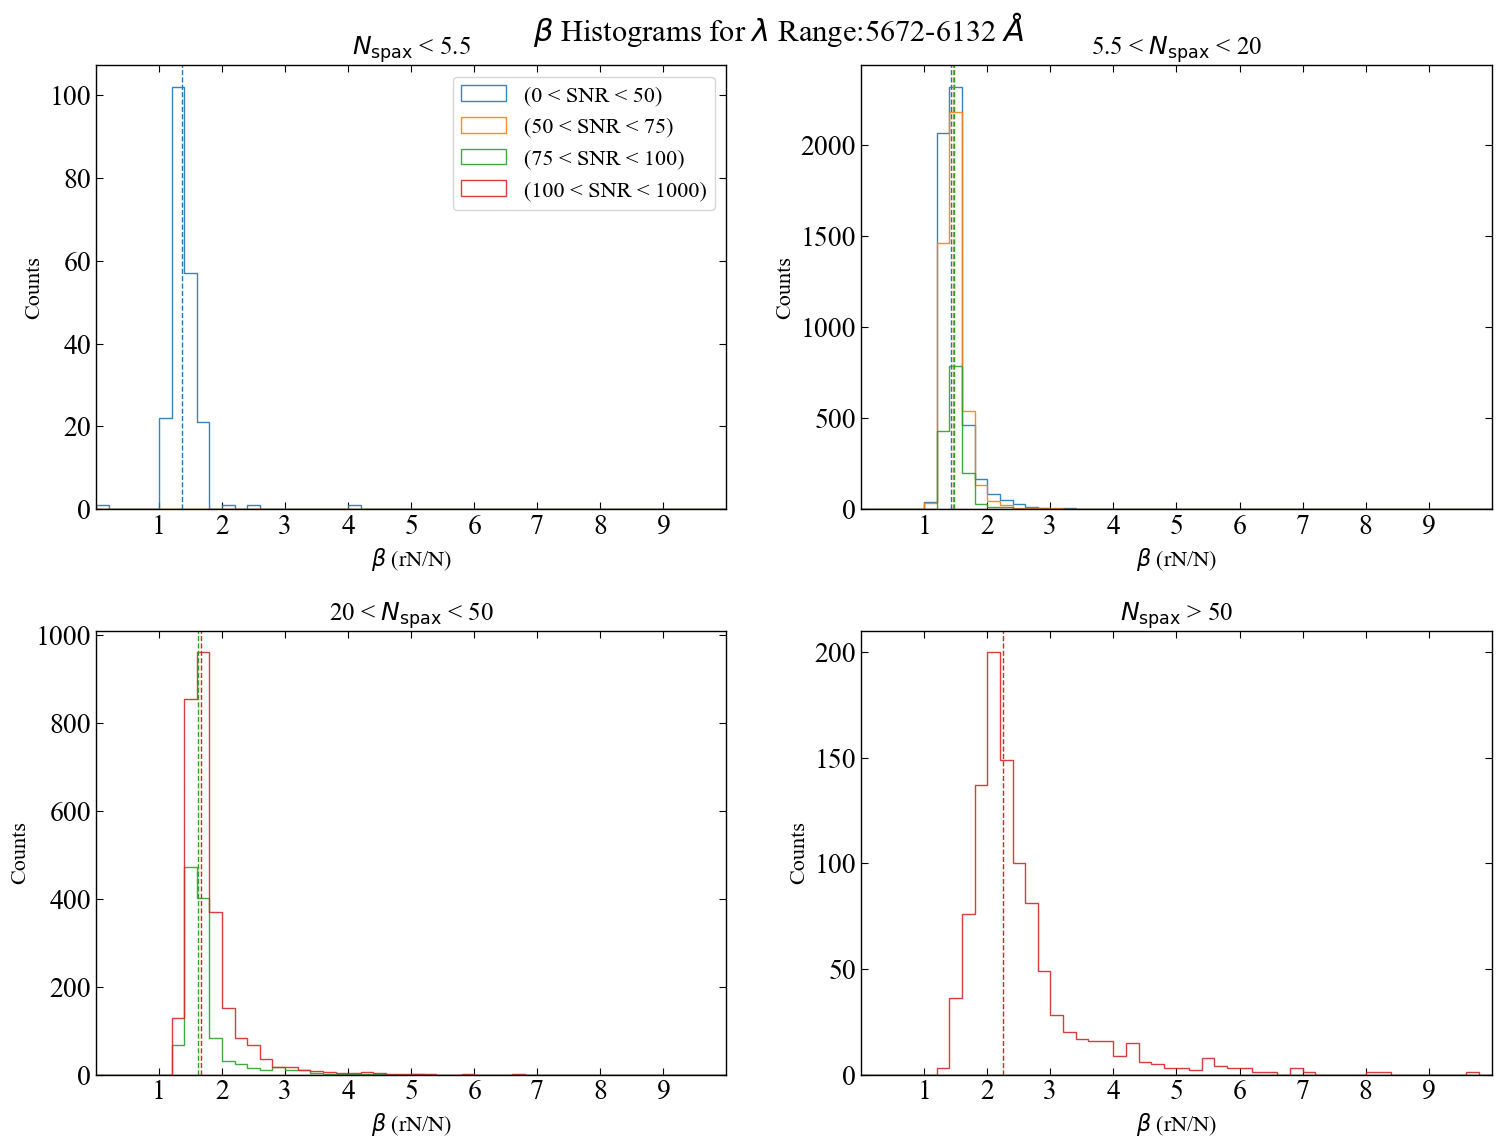

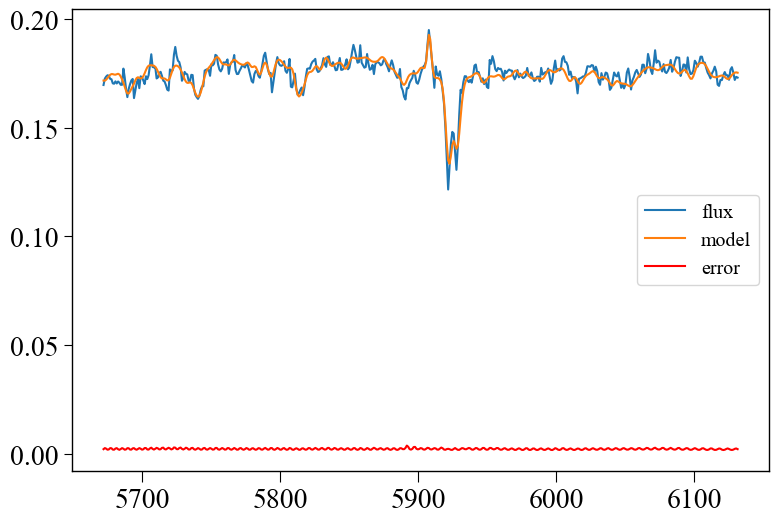

In [26]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot2, beta_tot2 = get_betaplots(bin_sort_real2,beta_sort_real2,SNR_sort_real2,wv_lims[2])

wv_lim = wv_lims[2]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


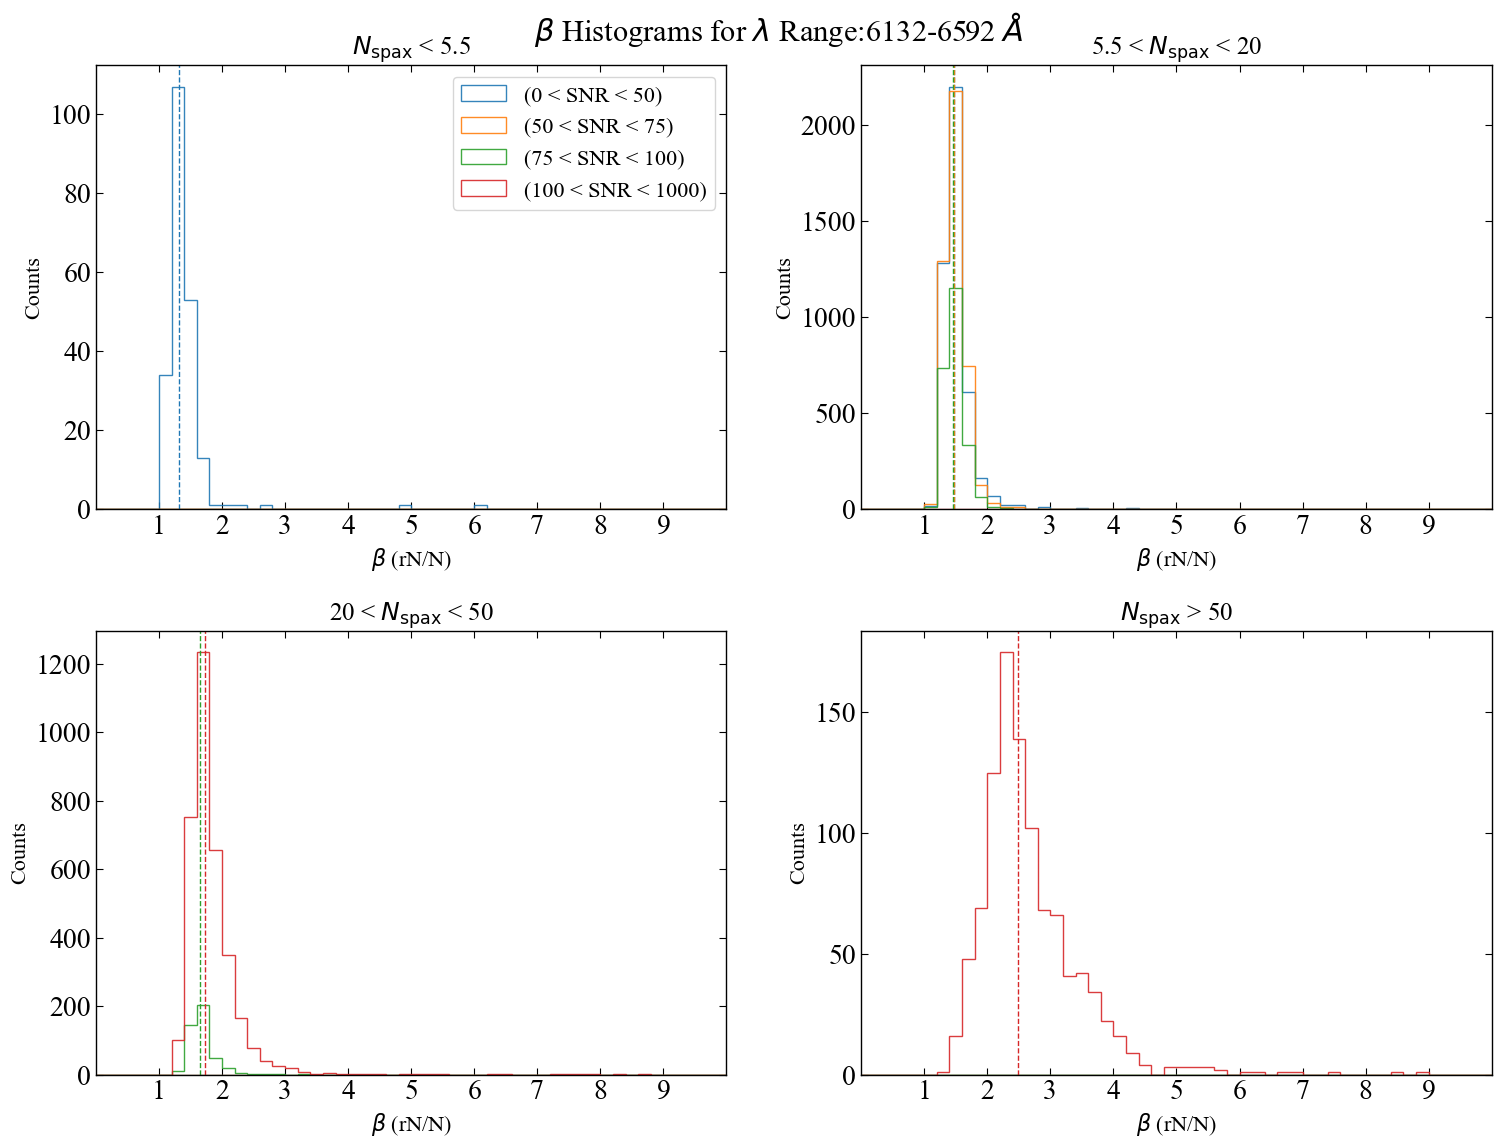

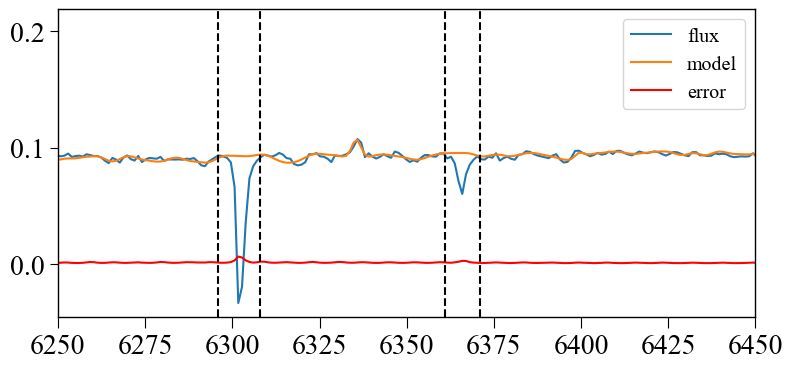

In [27]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot3, beta_tot3 = get_betaplots(bin_sort_real3,beta_sort_real3,SNR_sort_real3,wv_lims[3])

wv_lim = wv_lims[3]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,4))

#for i in range(np.max(binid_map3)+1):
for i in range(250,251):
    bin_indx = binid_map1 == i
    #plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],alpha=0.1)
    plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
    plt.plot(wave_filt1,mod_filt1[:,bin_indx][:,0],label='model')
    plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
#plt.ylim(0,1)
plt.xlim(6250,6450)
plt.axvline(6296,c='k',ls='--')
plt.axvline(6308,c='k',ls='--');
plt.axvline(6361,c='k',ls='--')
plt.axvline(6371,c='k',ls='--');
# plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
# plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
# plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

# S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# # get rms between flux and model
# rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# # caclulate beta value (rN/N)
# beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

# print('S/N: {:.2f}'.format(S_N))
# print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 87.16
beta: 3.79


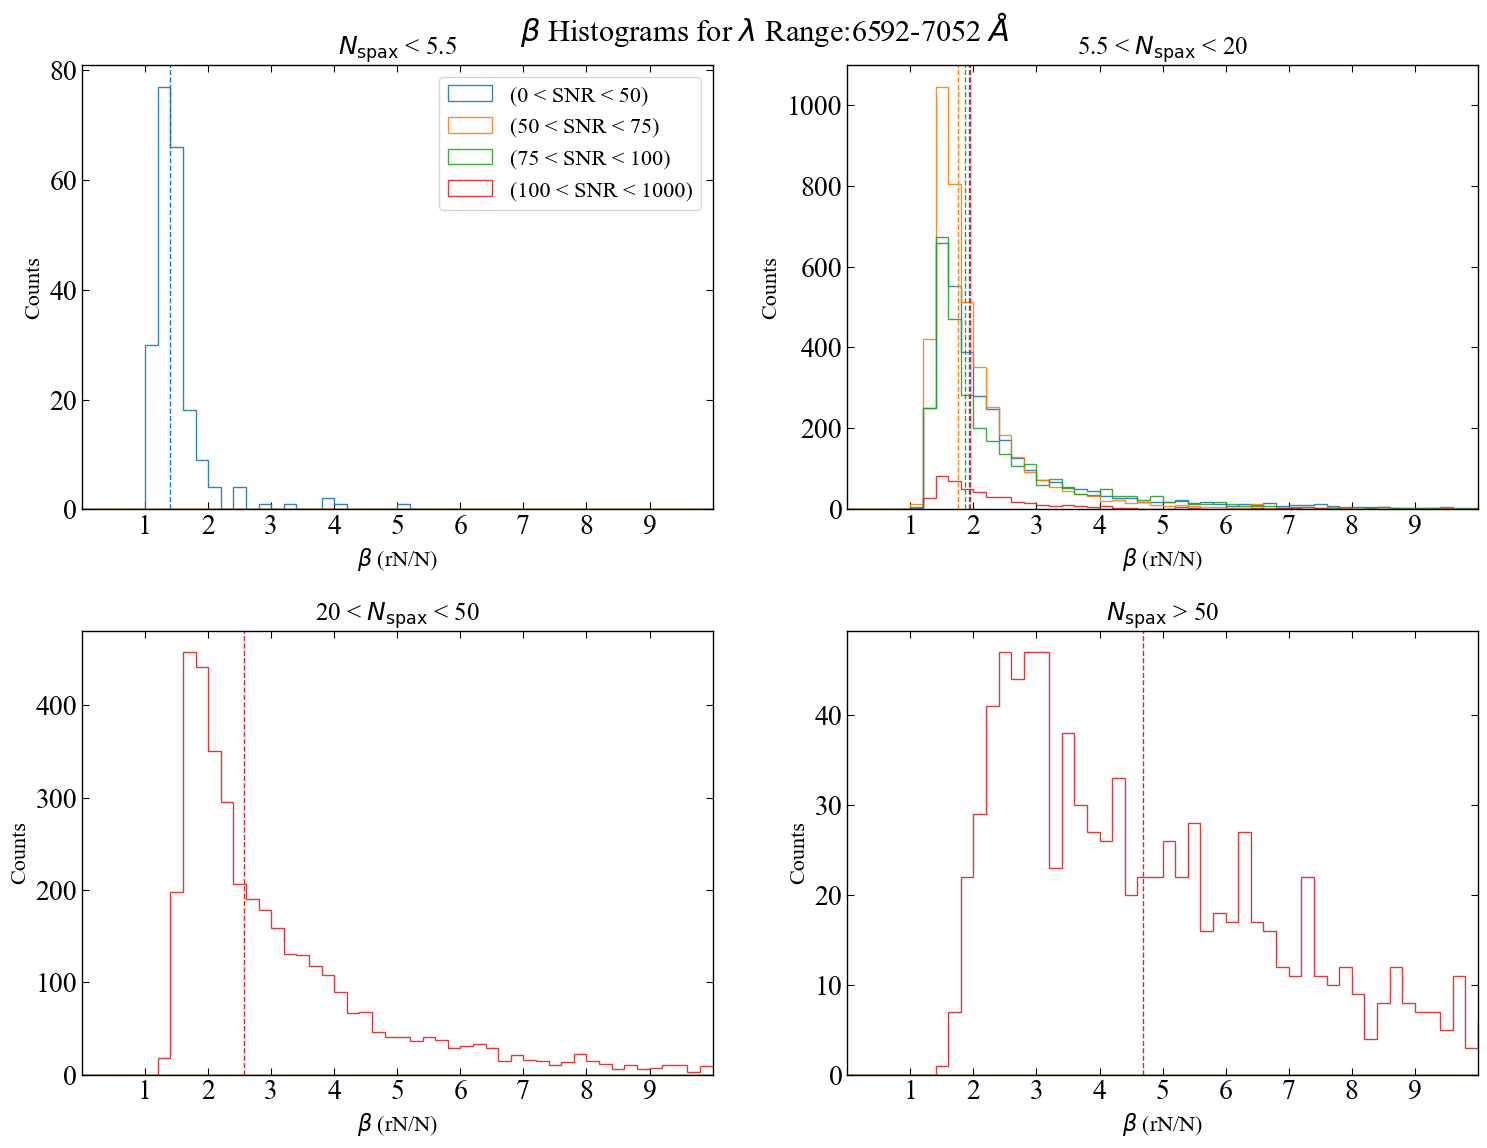

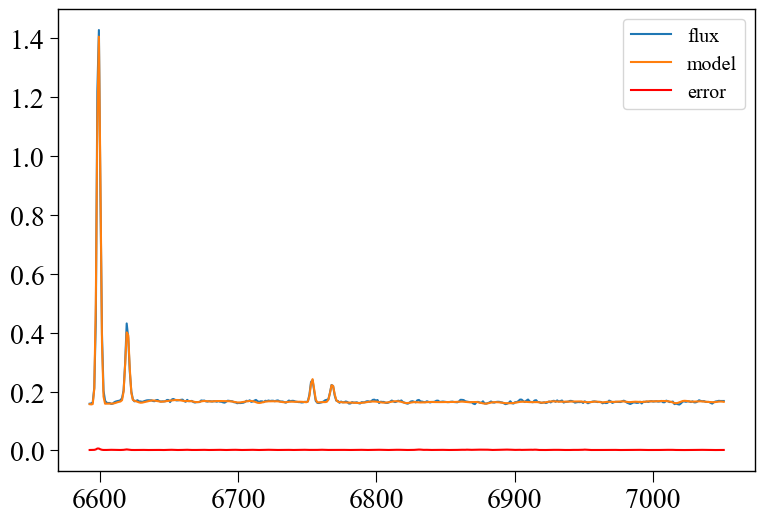

In [28]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot4, beta_tot4 = get_betaplots(bin_sort_real4,beta_sort_real4,SNR_sort_real4,wv_lims[4])

wv_lim = wv_lims[4]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 89.10
beta: 1.76


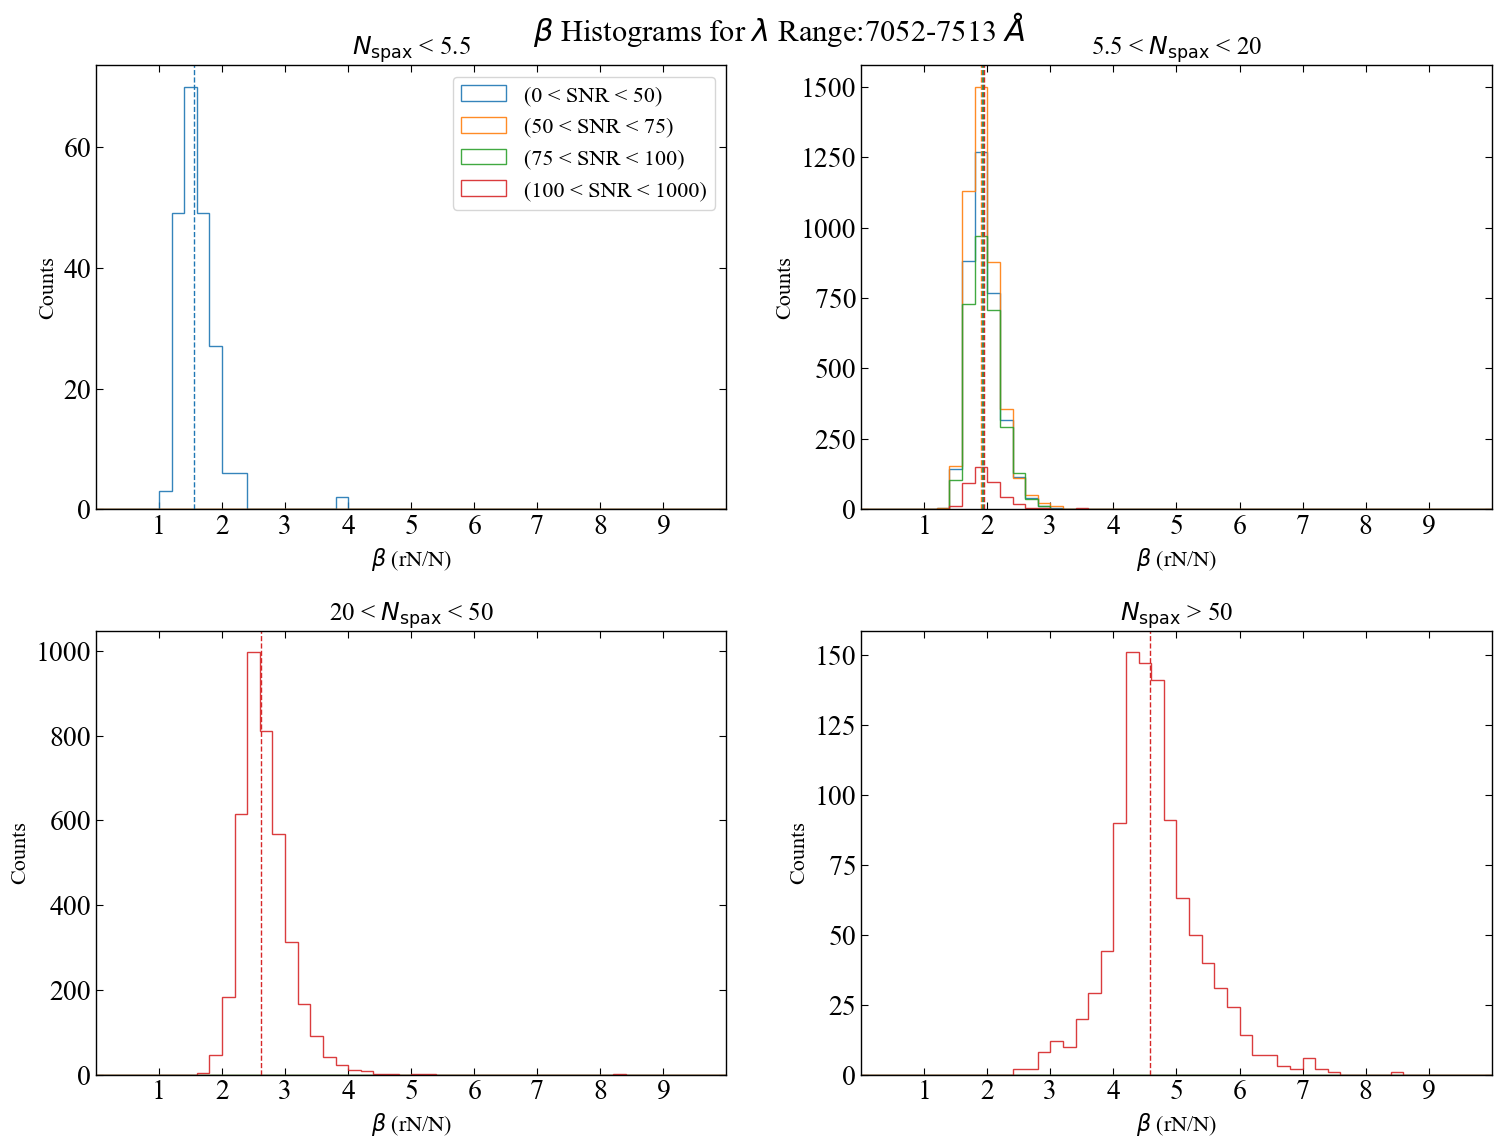

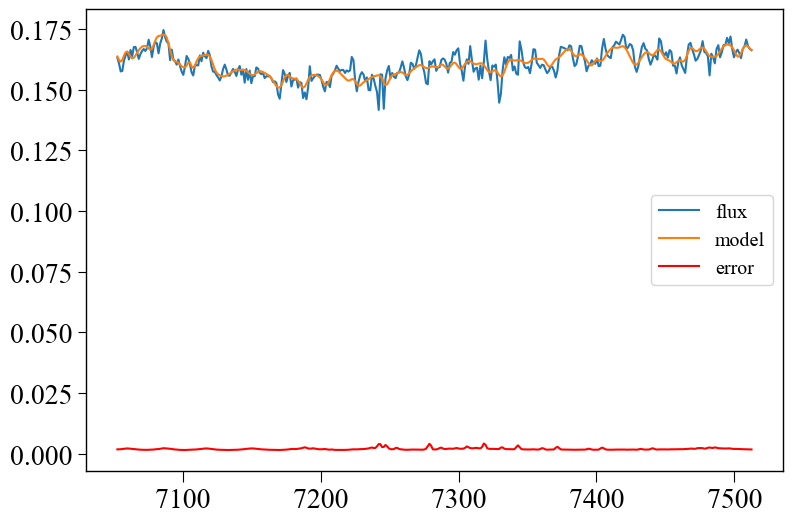

In [29]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot5, beta_tot5 = get_betaplots(bin_sort_real5,beta_sort_real5,SNR_sort_real5,wv_lims[5])

wv_lim = wv_lims[5]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 82.45
beta: 2.28


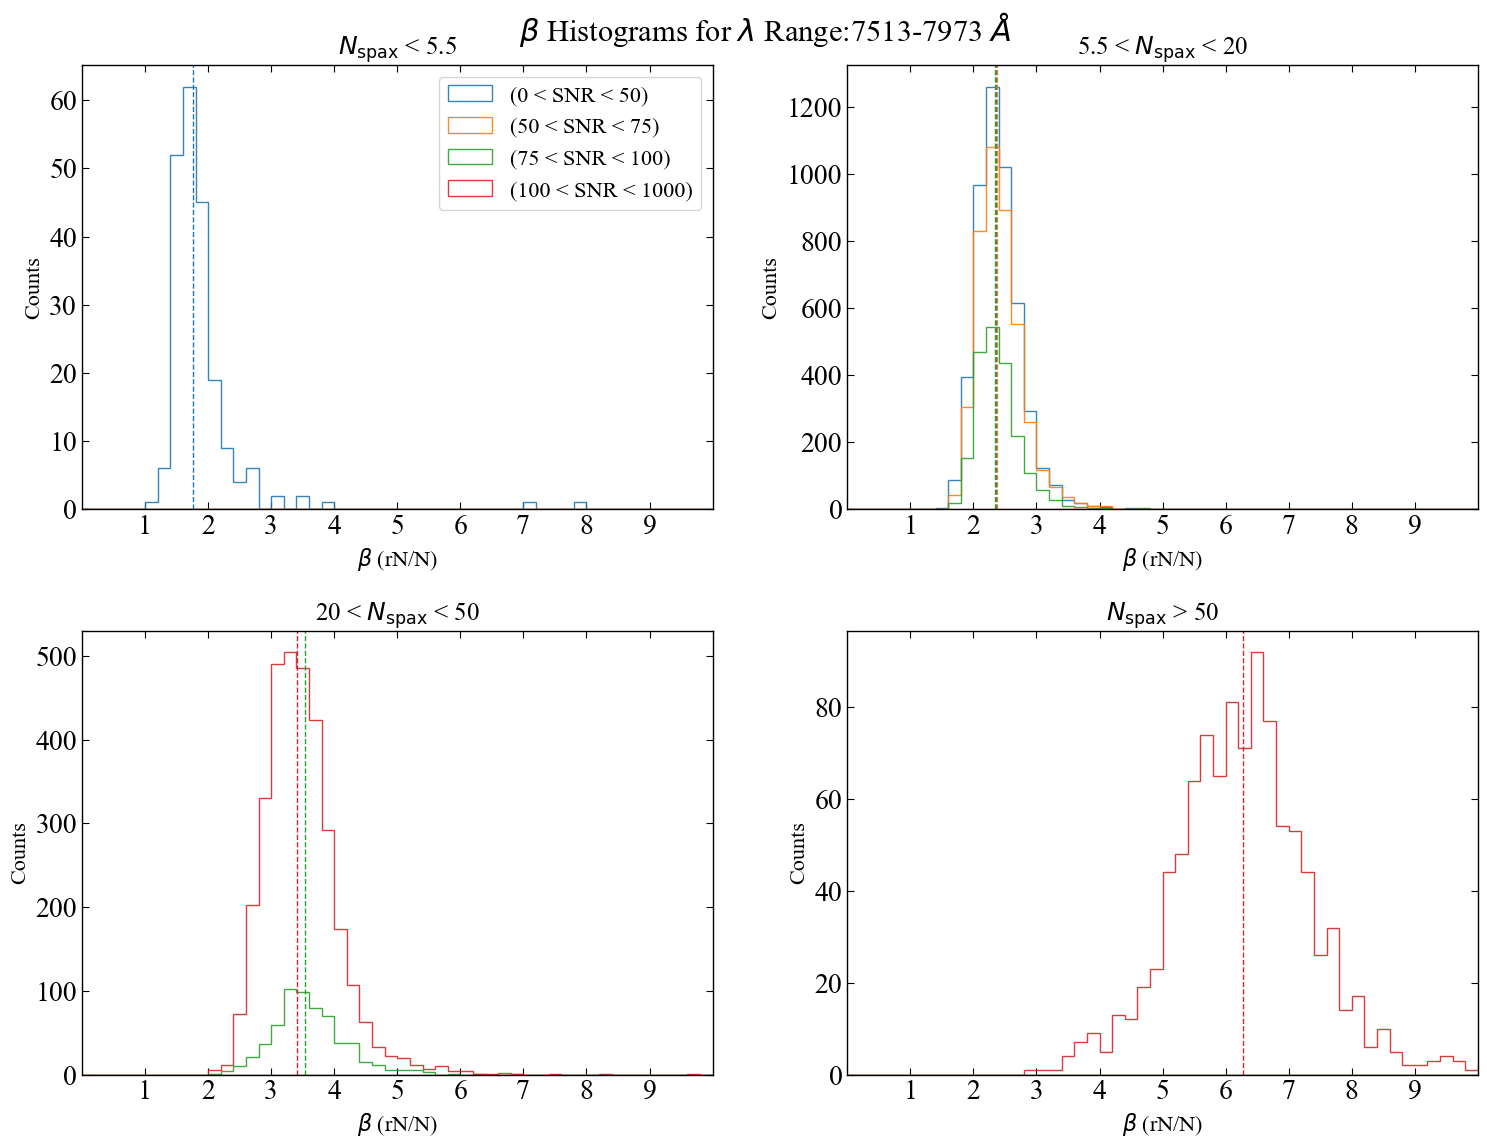

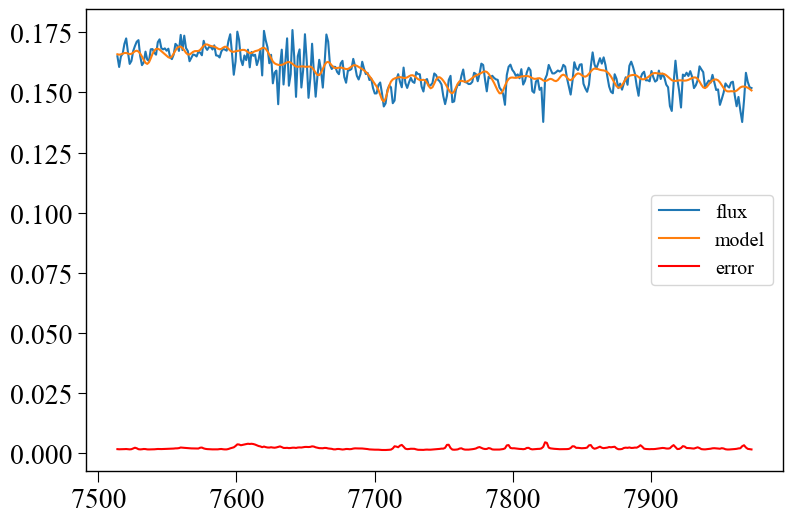

In [30]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot6, beta_tot6 = get_betaplots(bin_sort_real6,beta_sort_real6,SNR_sort_real6,wv_lims[6])

wv_lim = wv_lims[6]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 81.88
beta: 2.10


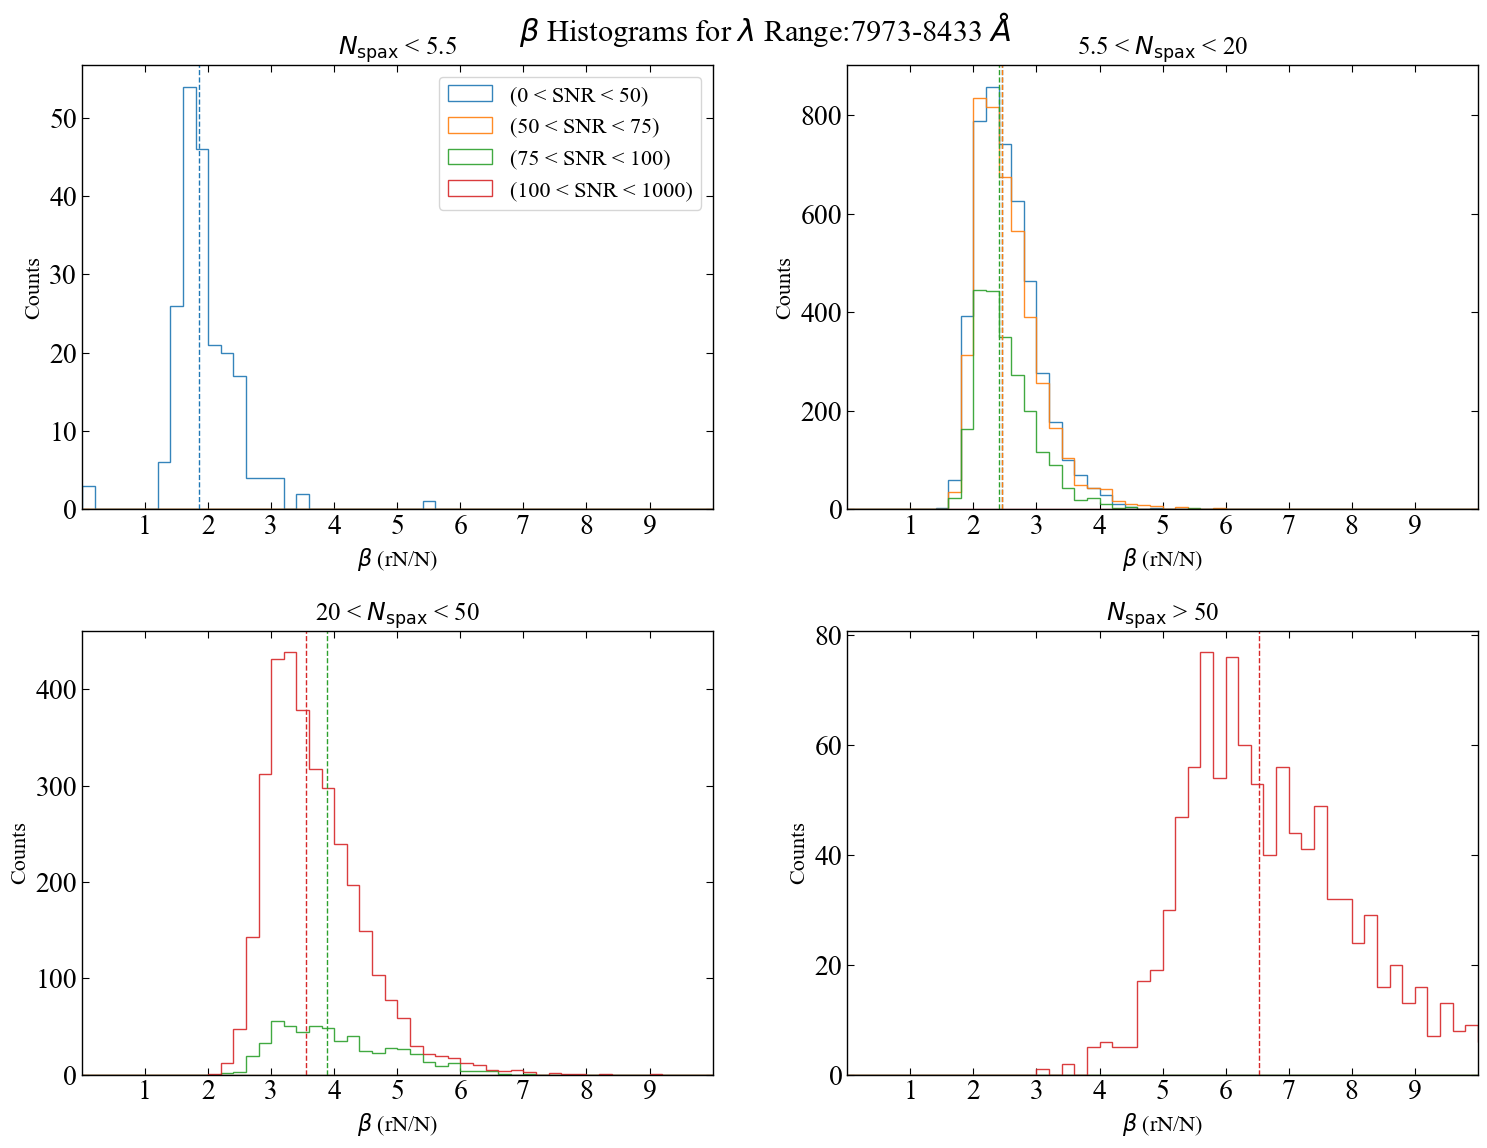

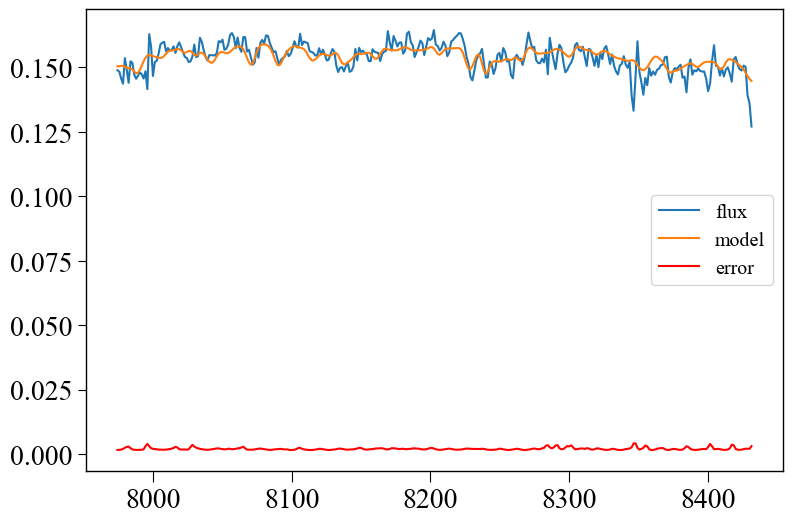

In [31]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot7, beta_tot7 = get_betaplots(bin_sort_real7,beta_sort_real7,SNR_sort_real7,wv_lims[7])

wv_lim = wv_lims[7]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 80.88
beta: 2.58


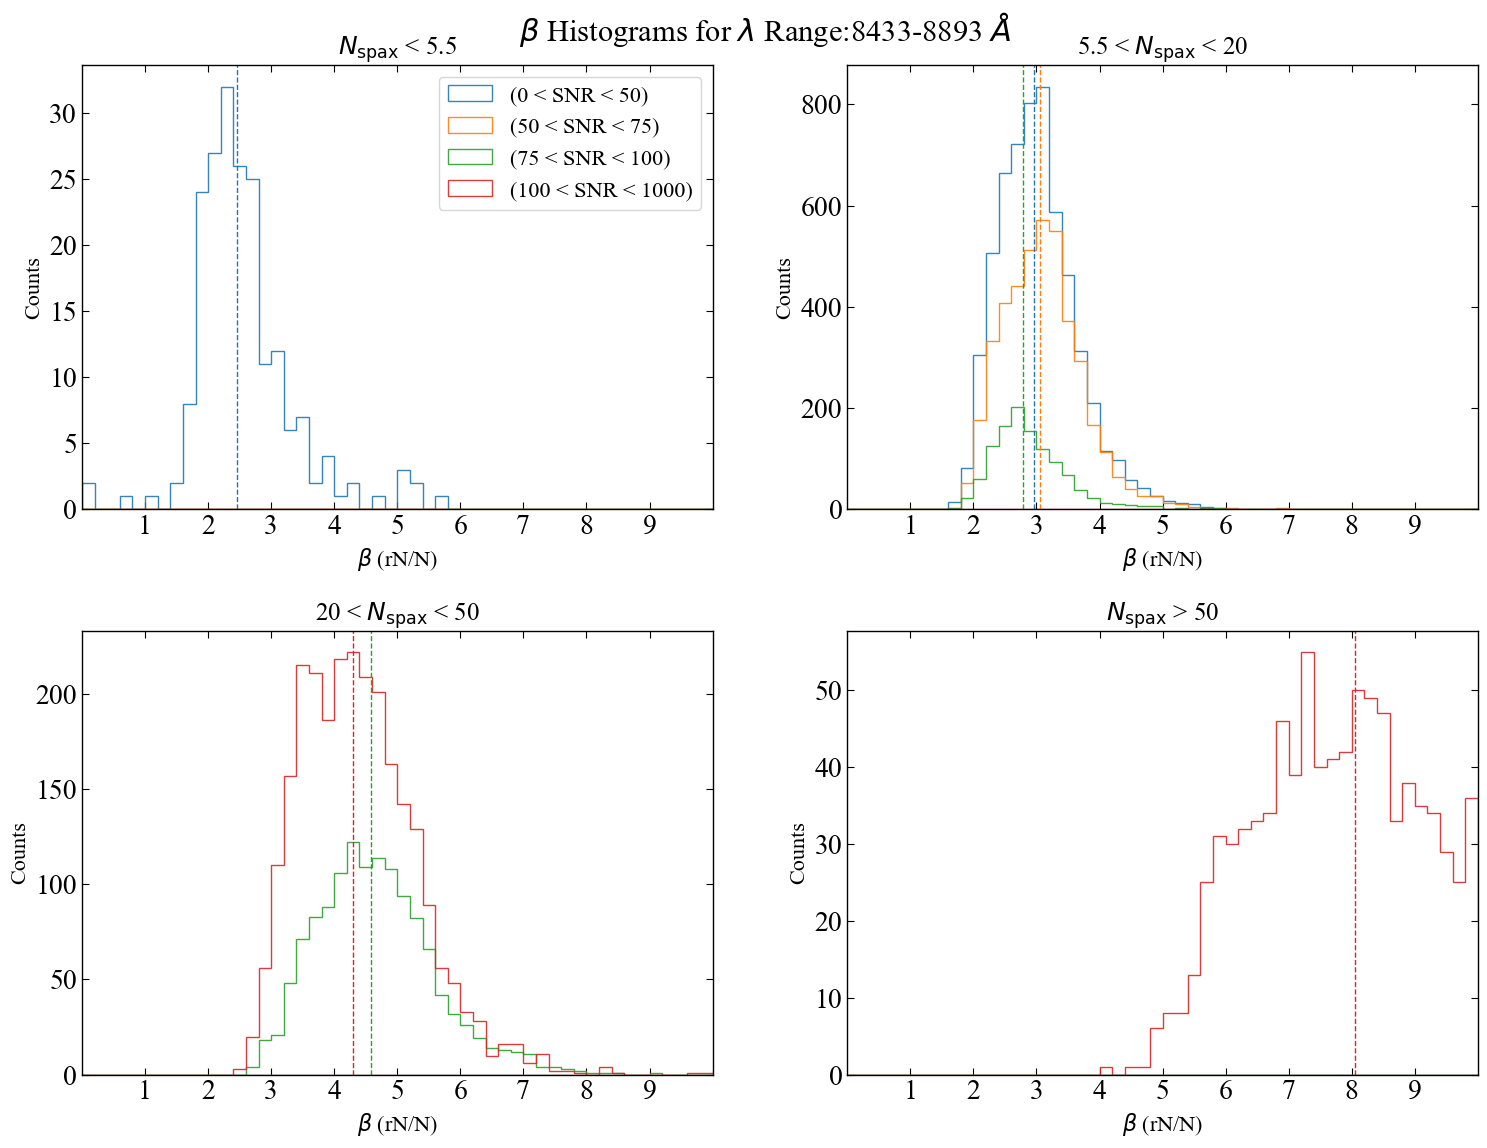

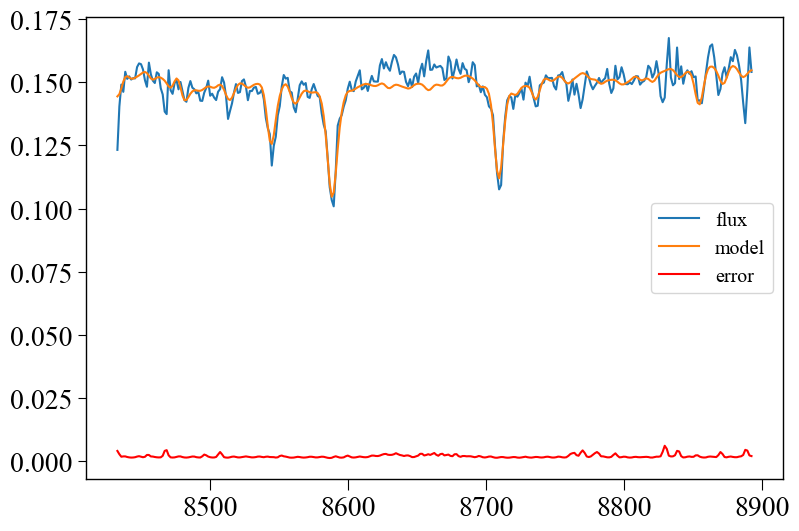

In [32]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot8, beta_tot8 = get_betaplots(bin_sort_real8,beta_sort_real8,SNR_sort_real8,wv_lims[8])

wv_lim = wv_lims[8]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])

print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


S/N: 71.31
beta: 3.69


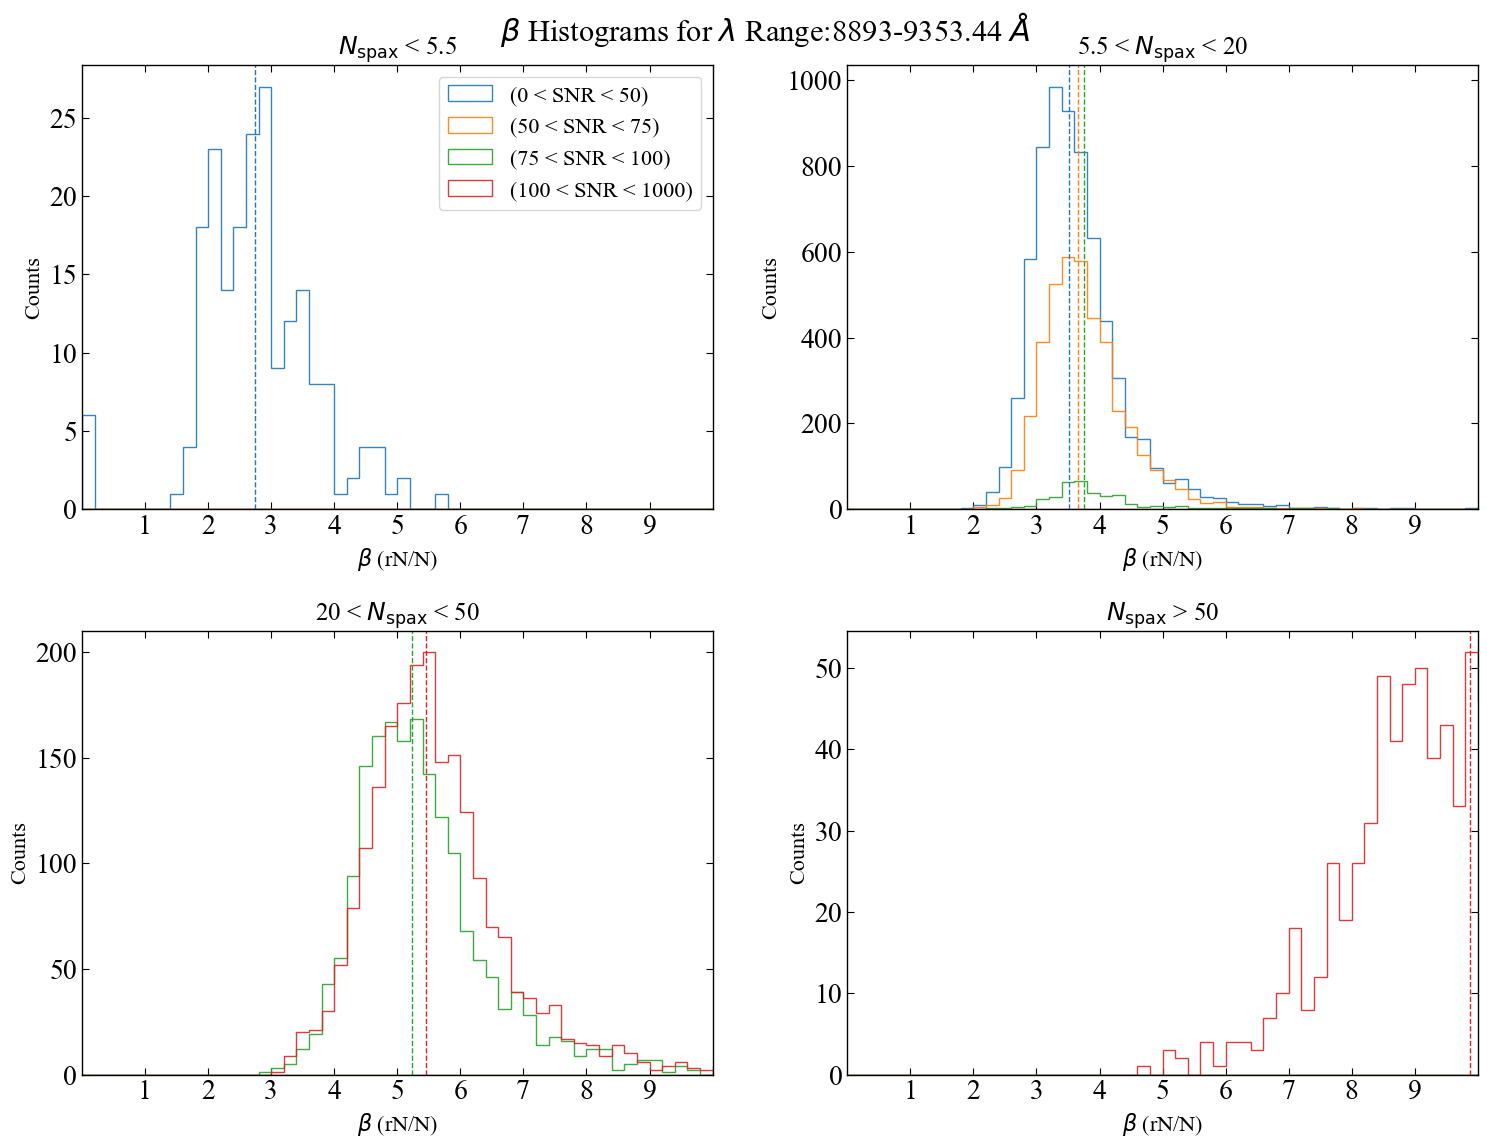

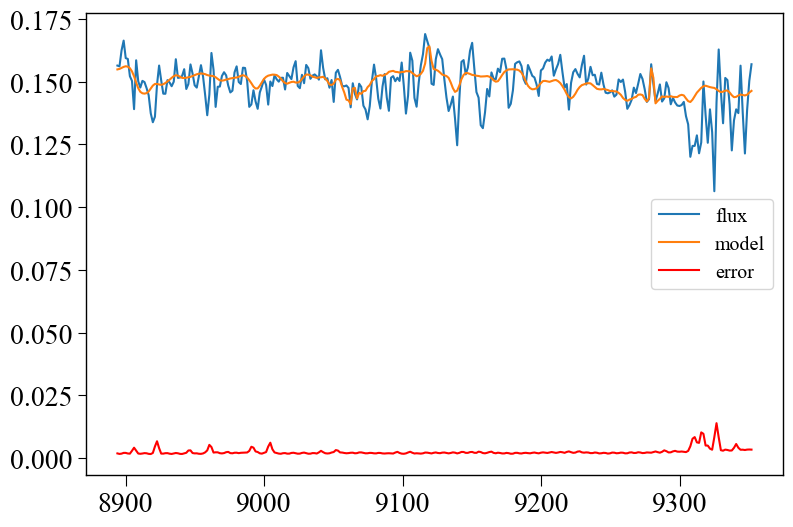

In [33]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]
bin_tot9, beta_tot9 = get_betaplots(bin_sort_real9,beta_sort_real9,SNR_sort_real9,wv_lims[9])

wv_lim = wv_lims[9]

# select wavelength range
spec_filt1 = spec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
mod_filt1 = mod1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
espec_filt1 = espec1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
wave_filt1 = wave1[(wave1 >  wv_lim[0]) & (wave1 <  wv_lim[1])]
plt.figure(figsize=(9,6))
plt.rcParams['figure.figsize'] = (8,6)

bin_id = 25
bin_indx = binid_map1 == bin_id 
plt.plot(wave_filt1,spec_filt1[:,bin_indx][:,0],label='flux')
plt.plot(wave_filt1, mod_filt1[:,bin_indx][:,0],label='model')
plt.plot(wave_filt1, espec_filt1[:,bin_indx][:,0],label='error',c='red')
plt.legend(fontsize='x-large');

S_N = np.median(spec_filt1[:,bin_indx][:,0]/espec_filt1[:,bin_indx][:,0])
# get rms between flux and model
rms = np.sqrt( np.mean( (spec_filt1[:,bin_indx][:,0] - mod_filt1[:,bin_indx][:,0])**2 ) )
# caclulate beta value (rN/N)
beta = rms/np.median(espec_filt1[:,bin_indx][:,0])
print('S/N: {:.2f}'.format(S_N))
print('beta: {:.2f}'.format(beta))

/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/erickaguirre/miniconda3/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: in

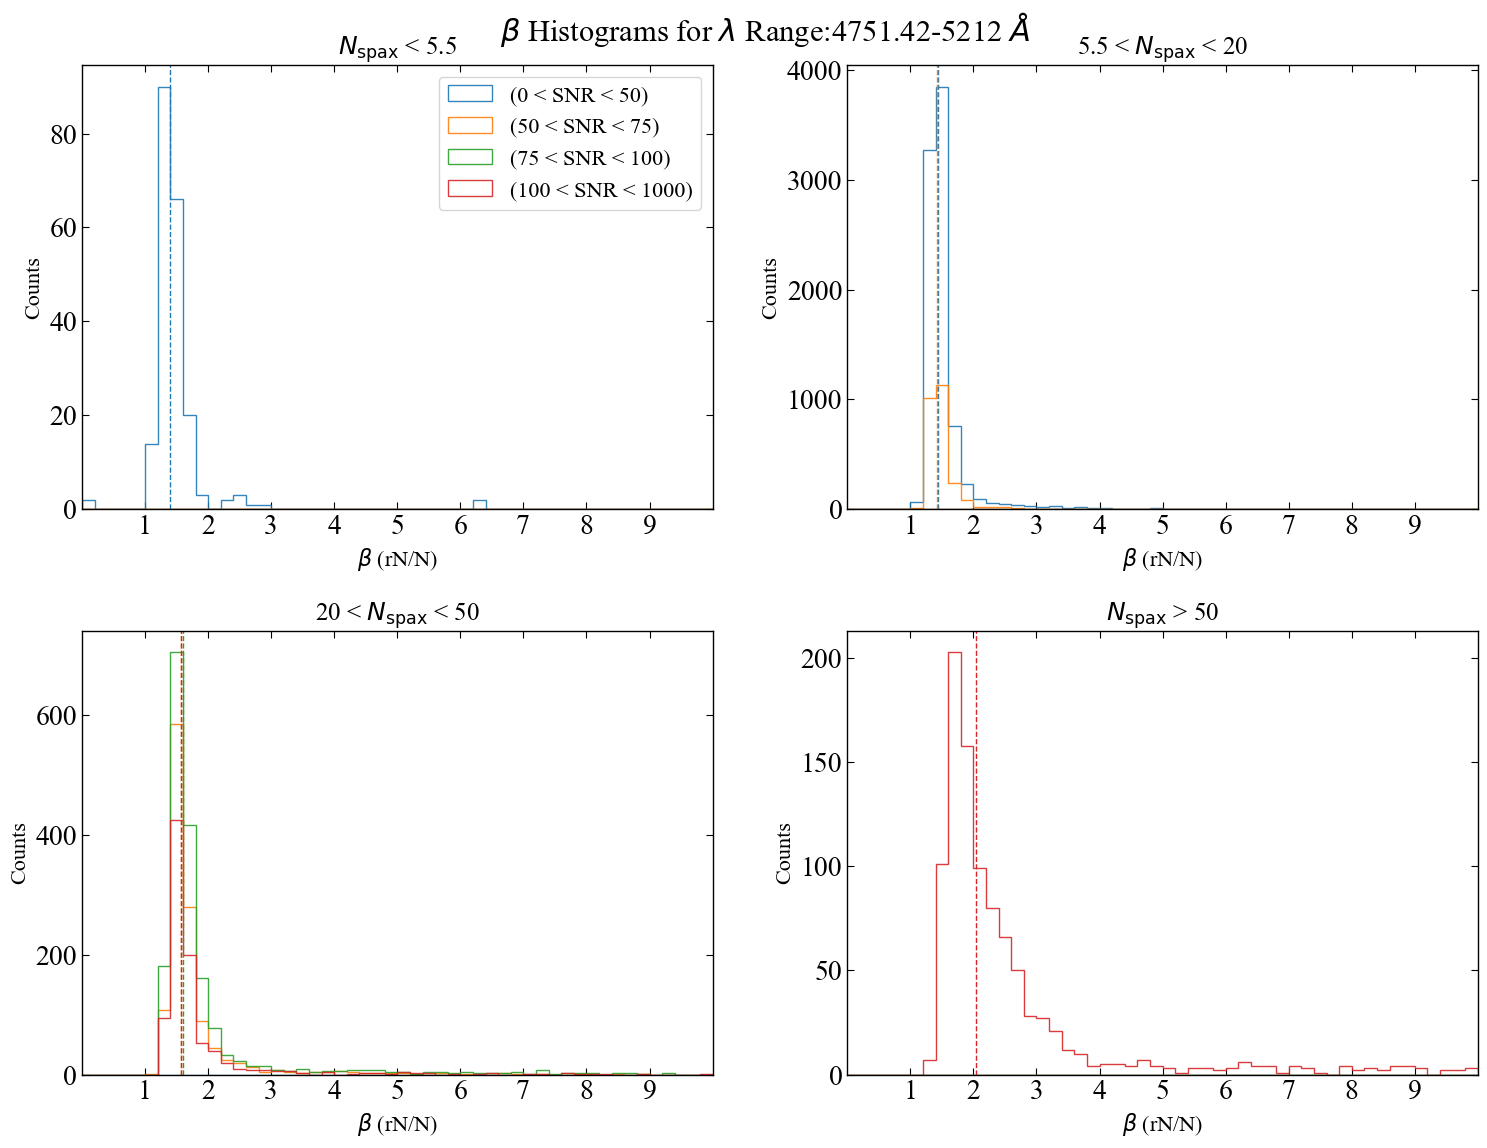

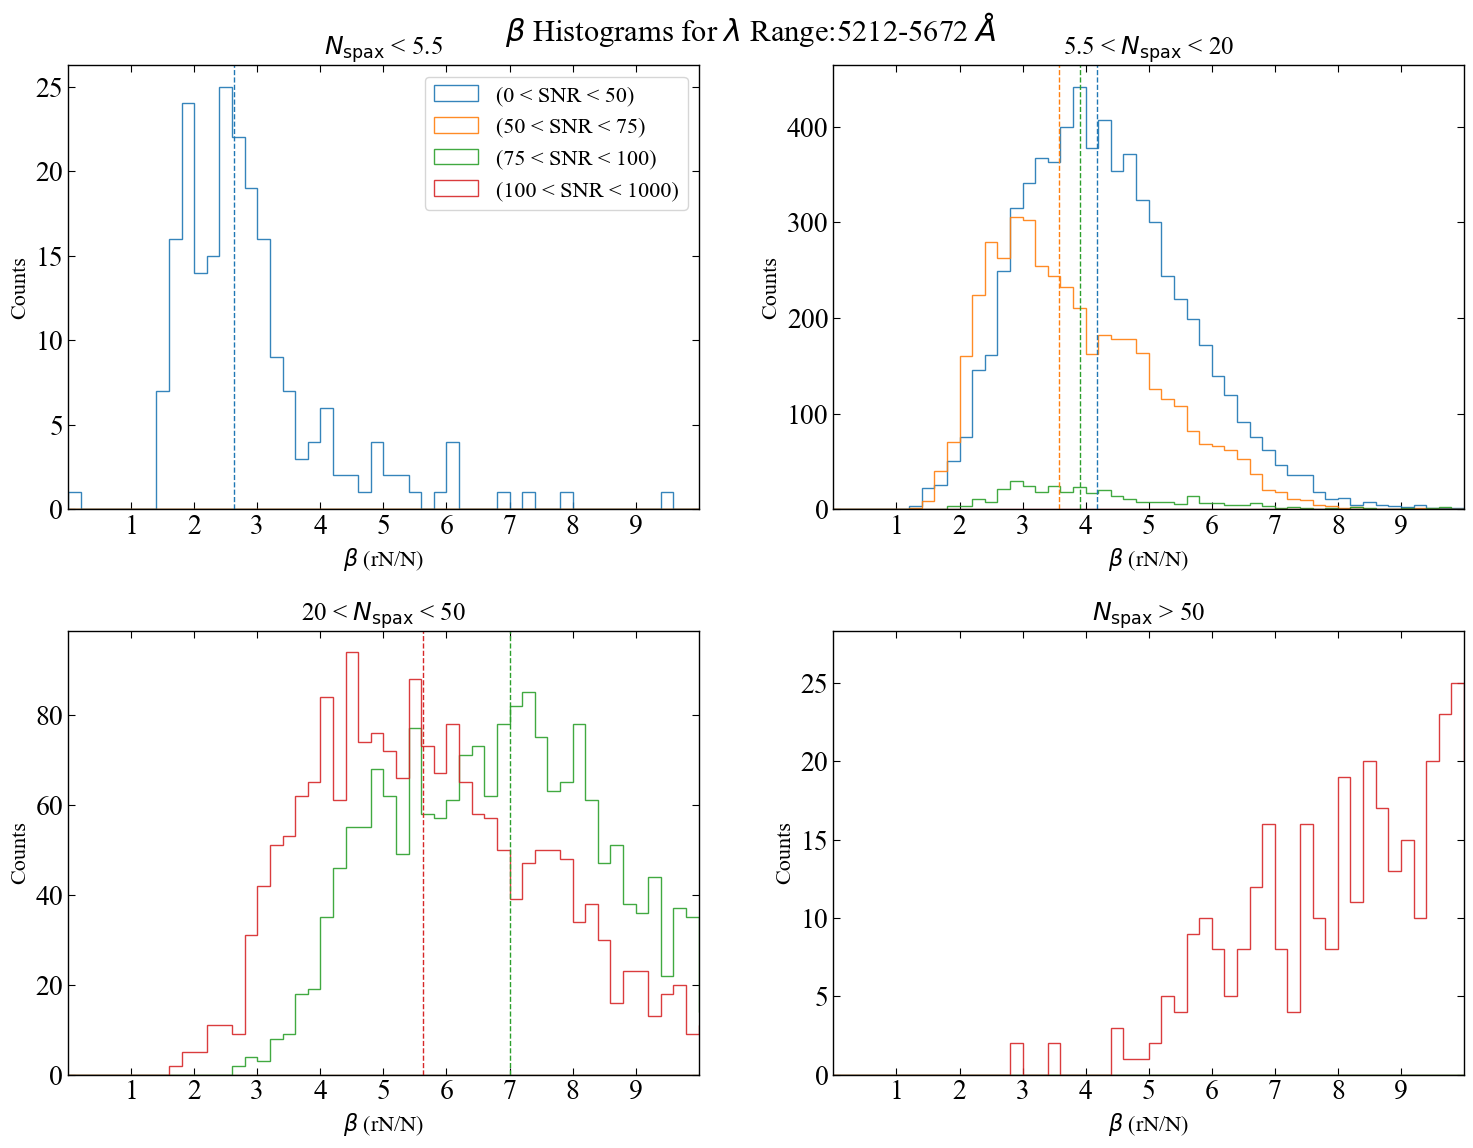

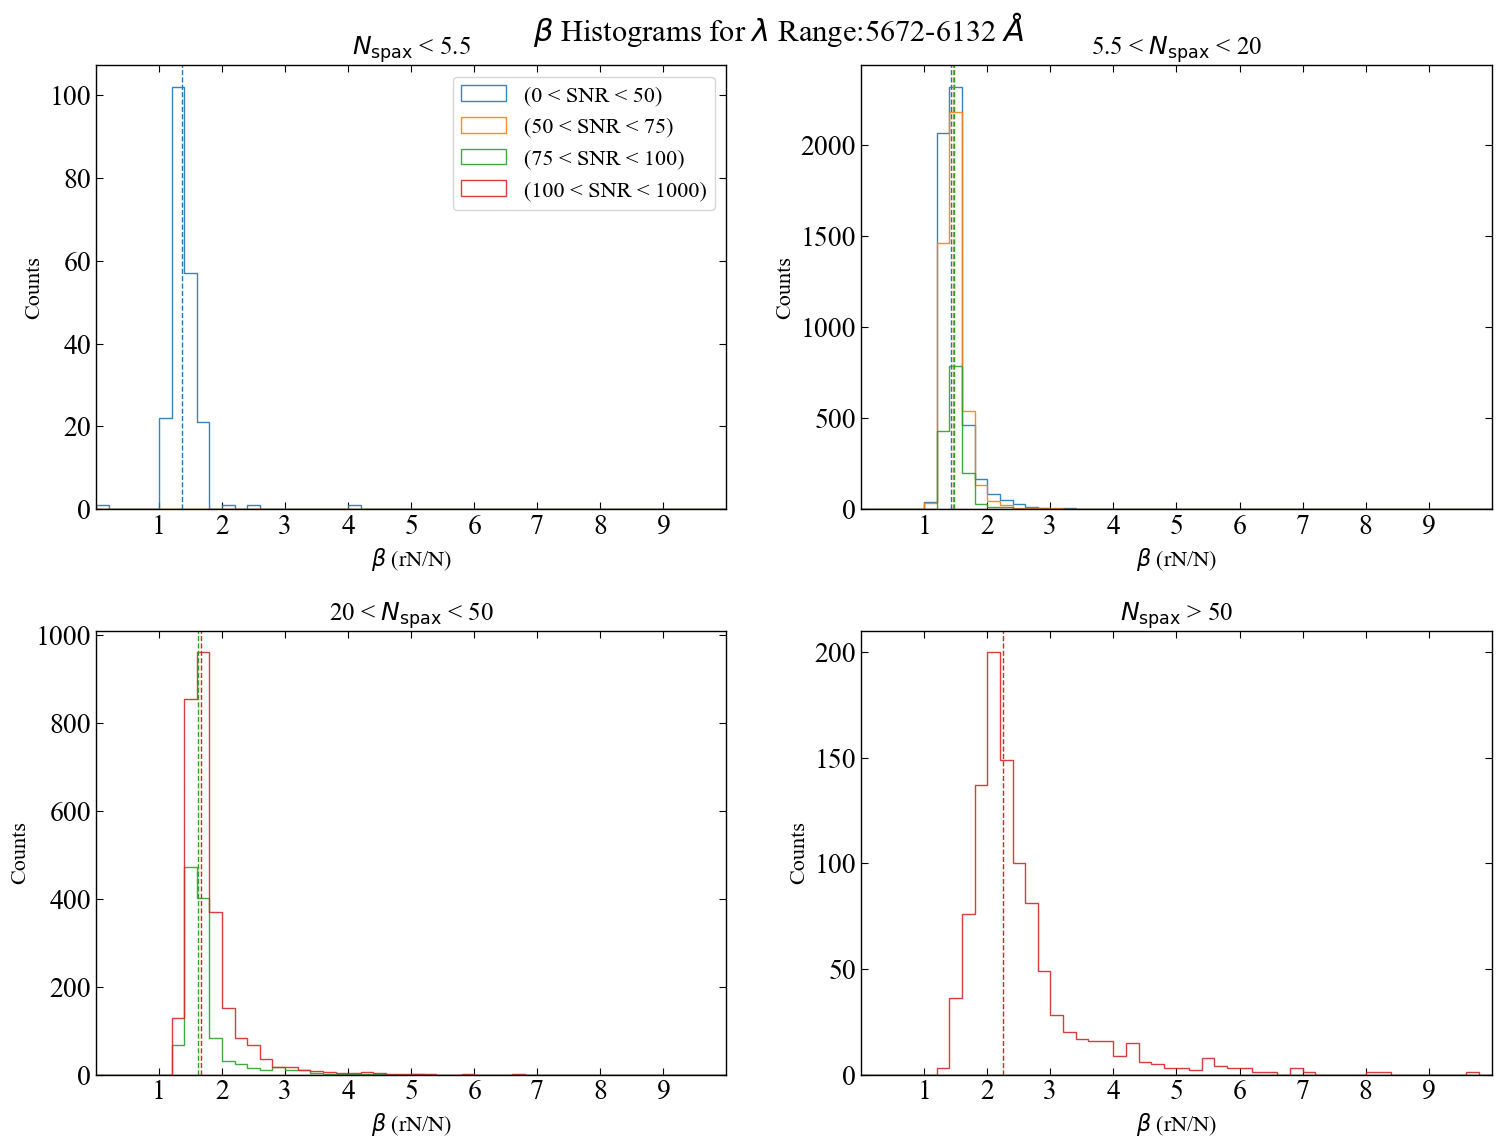

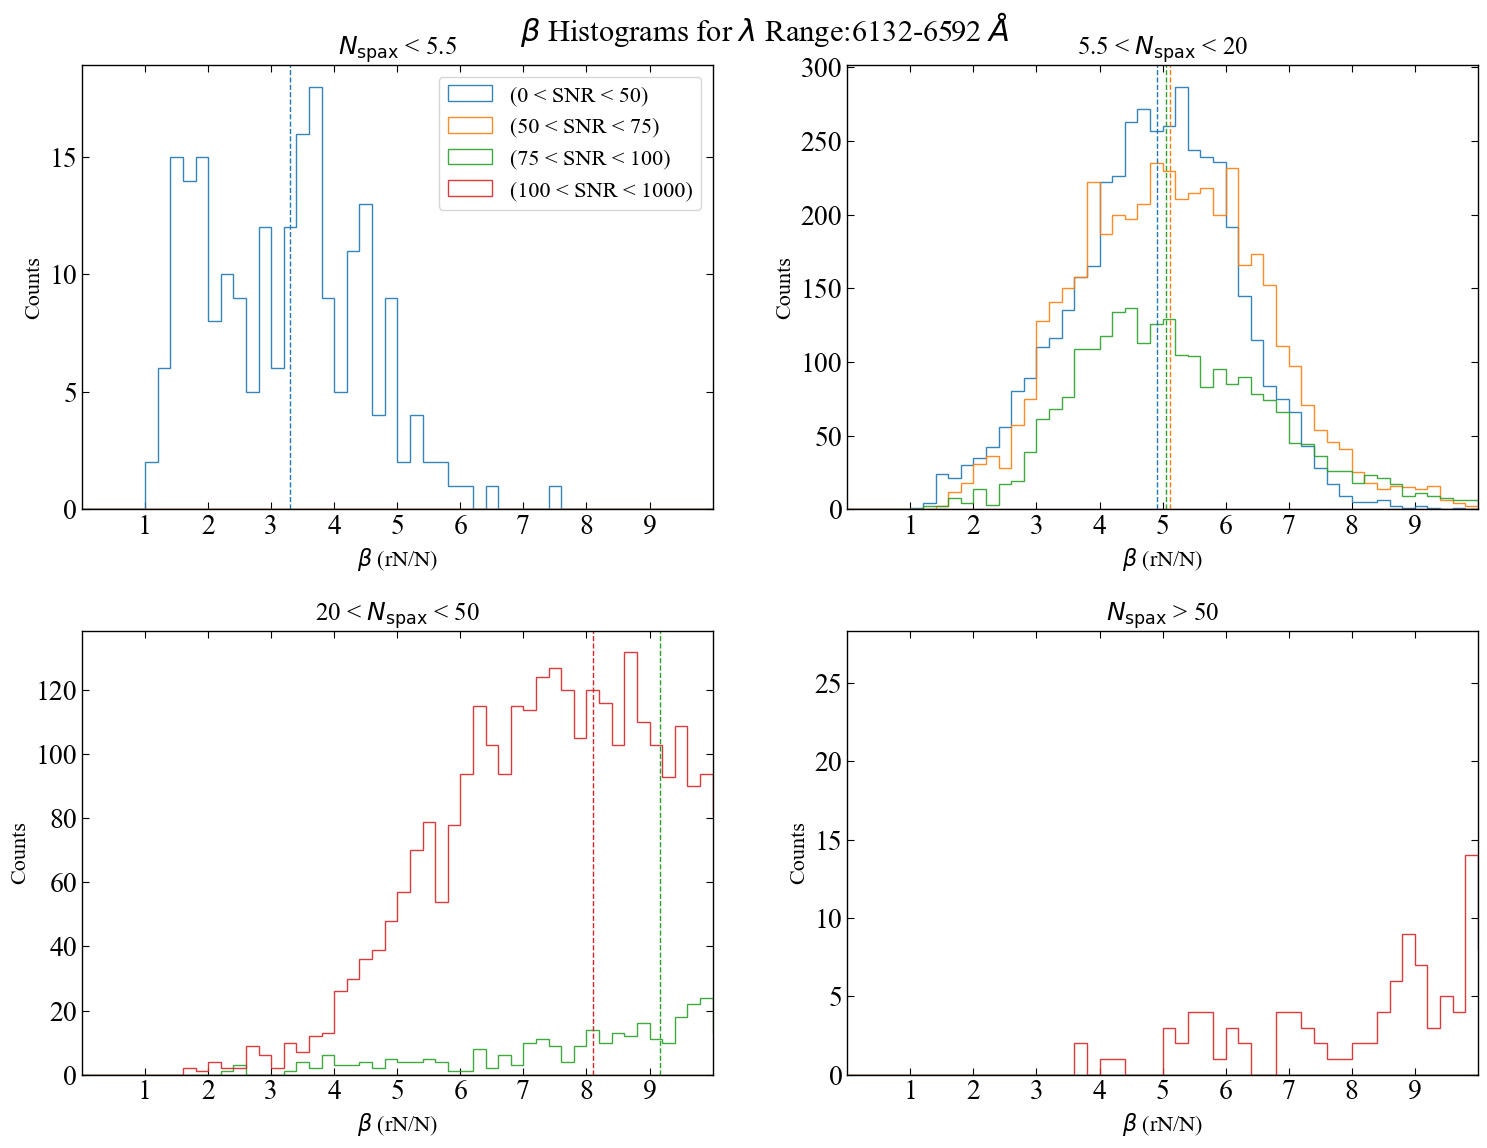

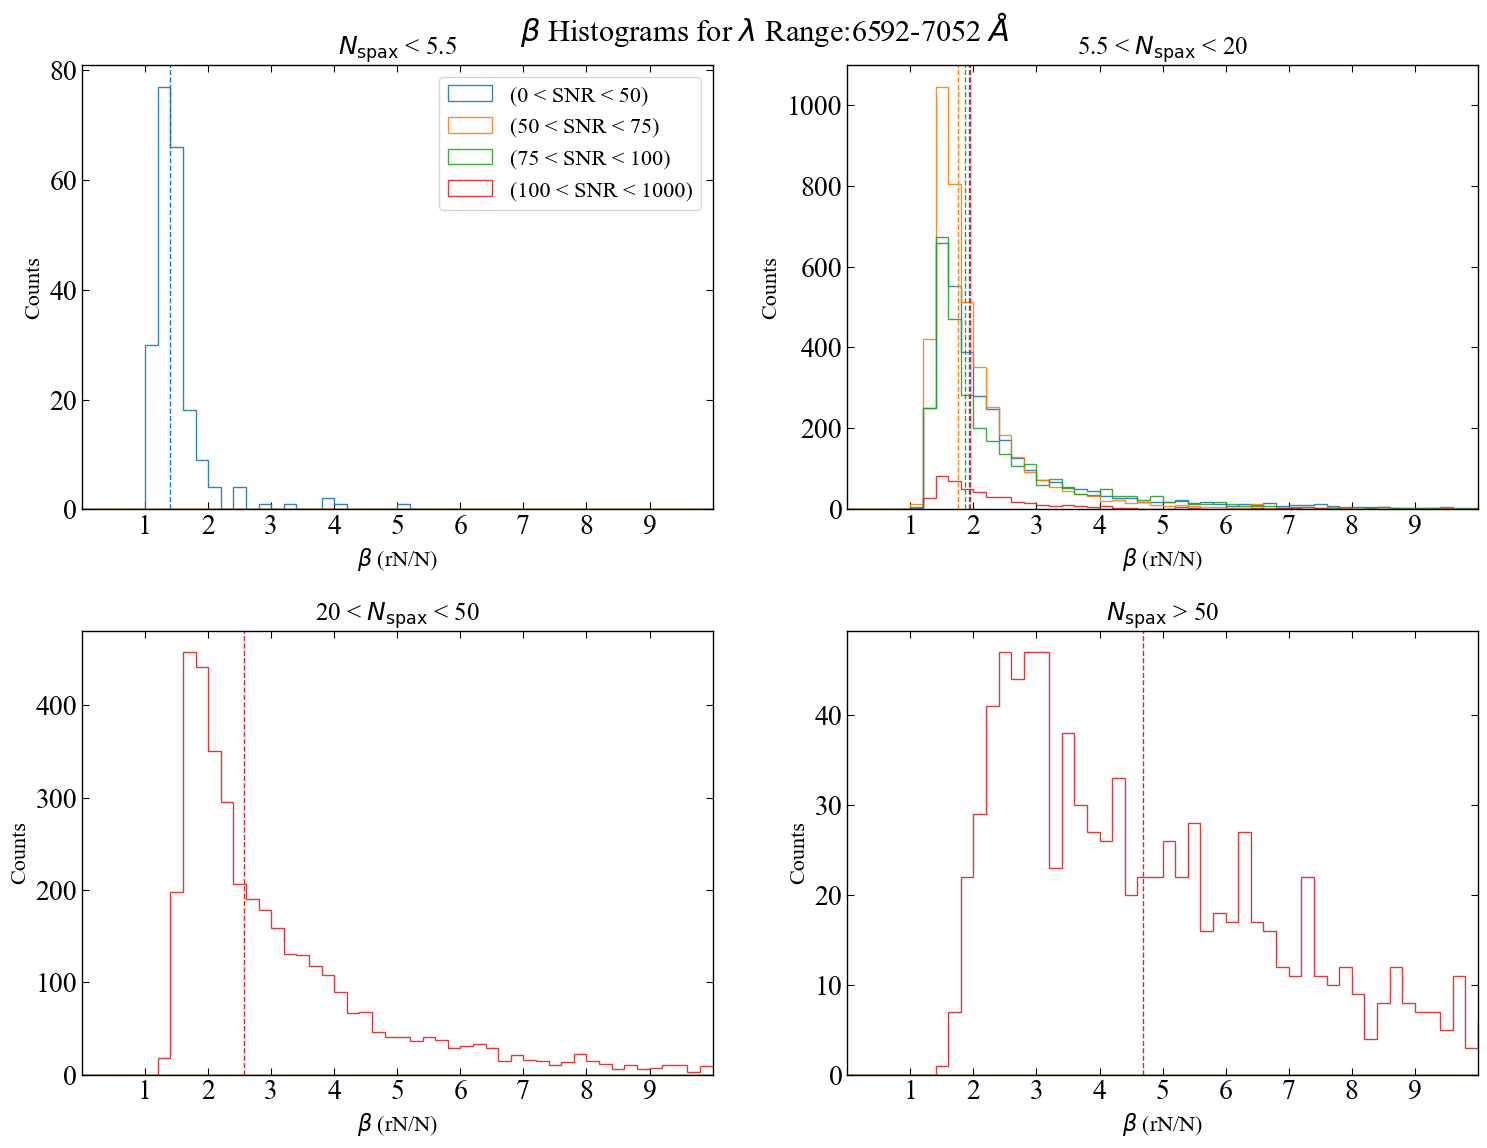

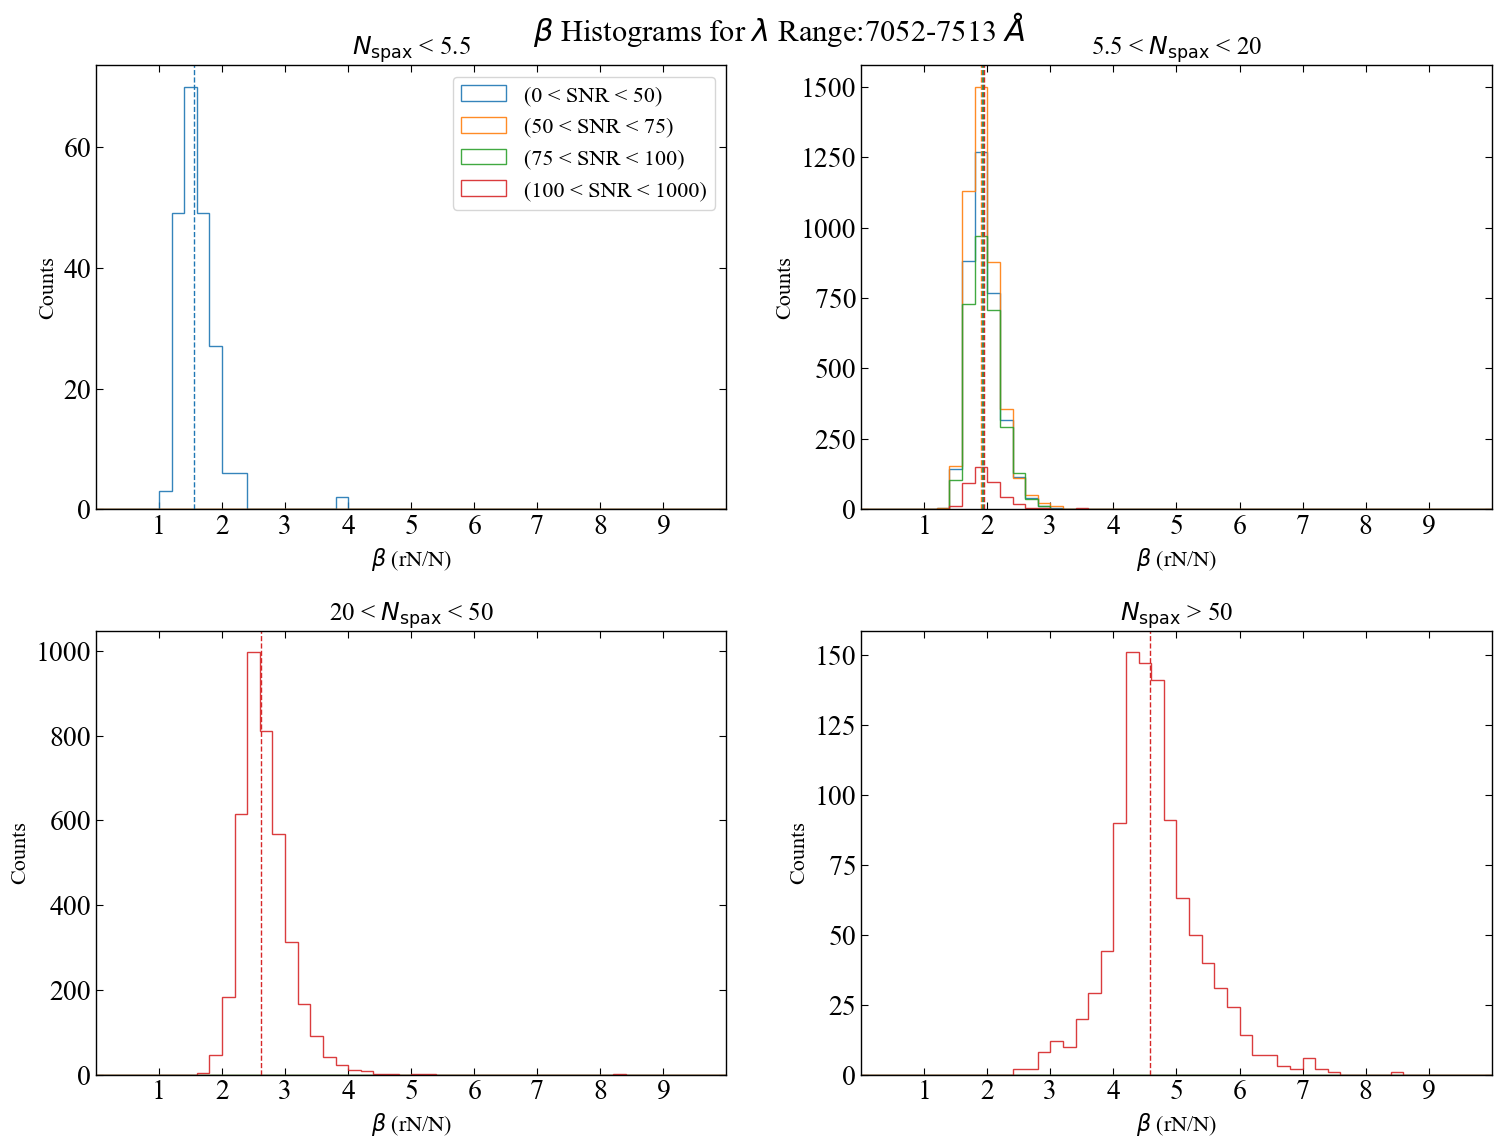

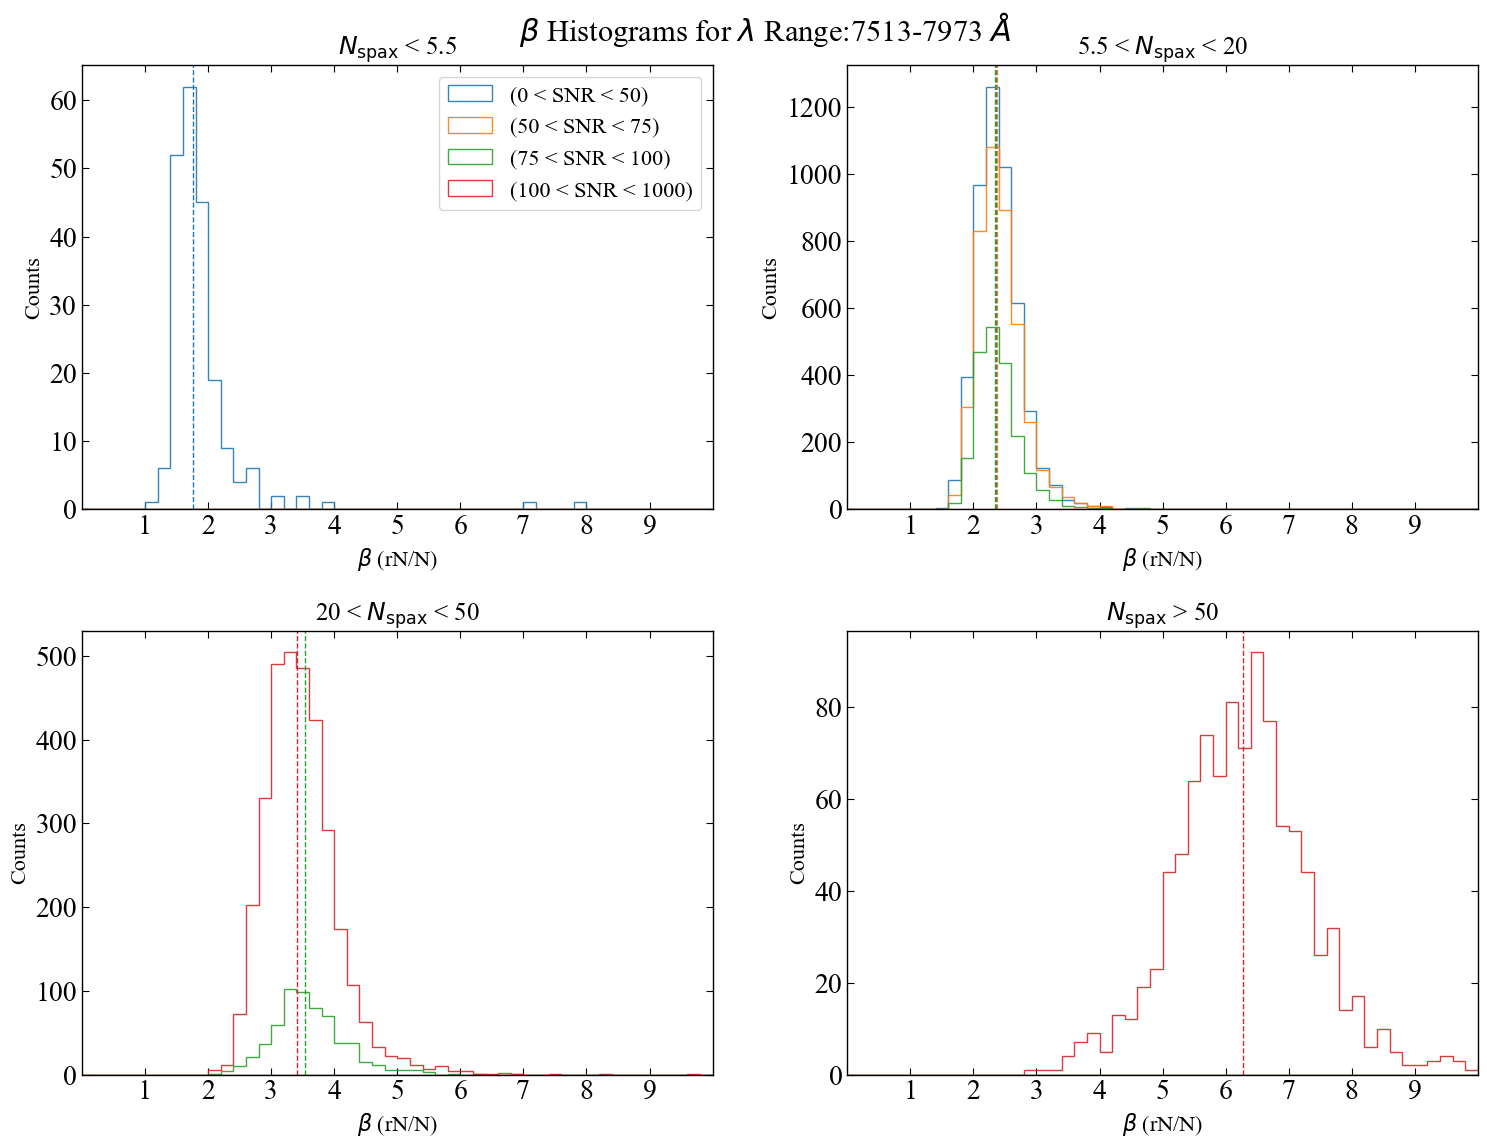

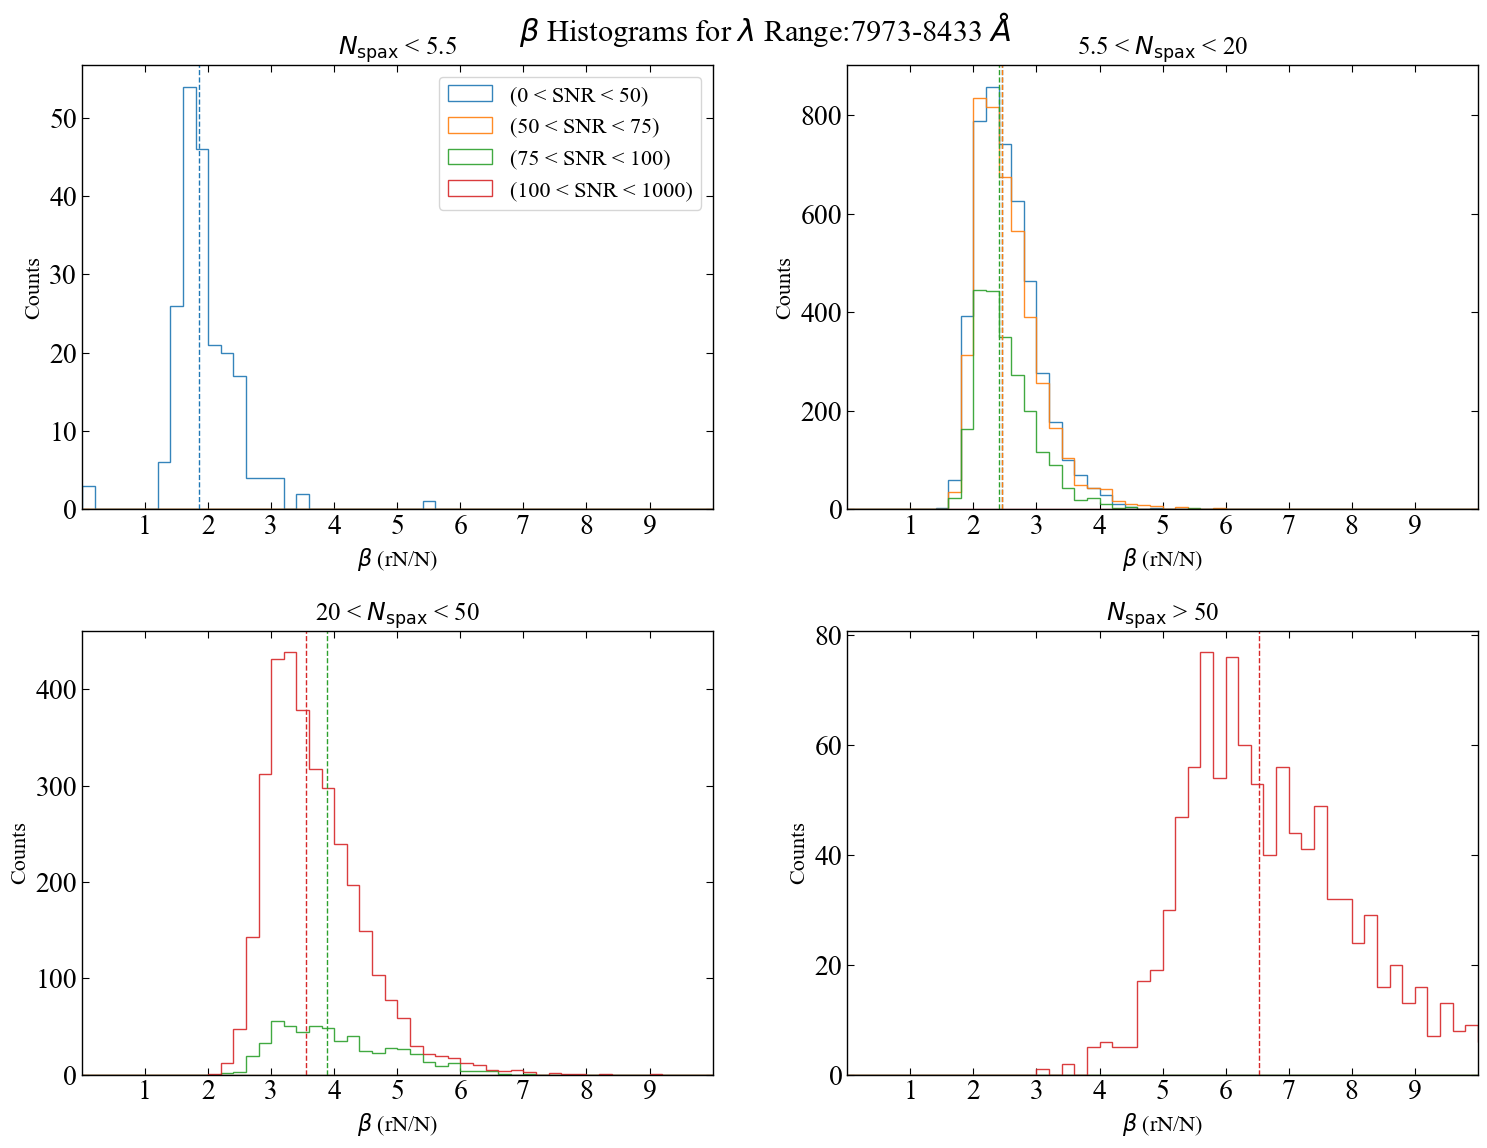

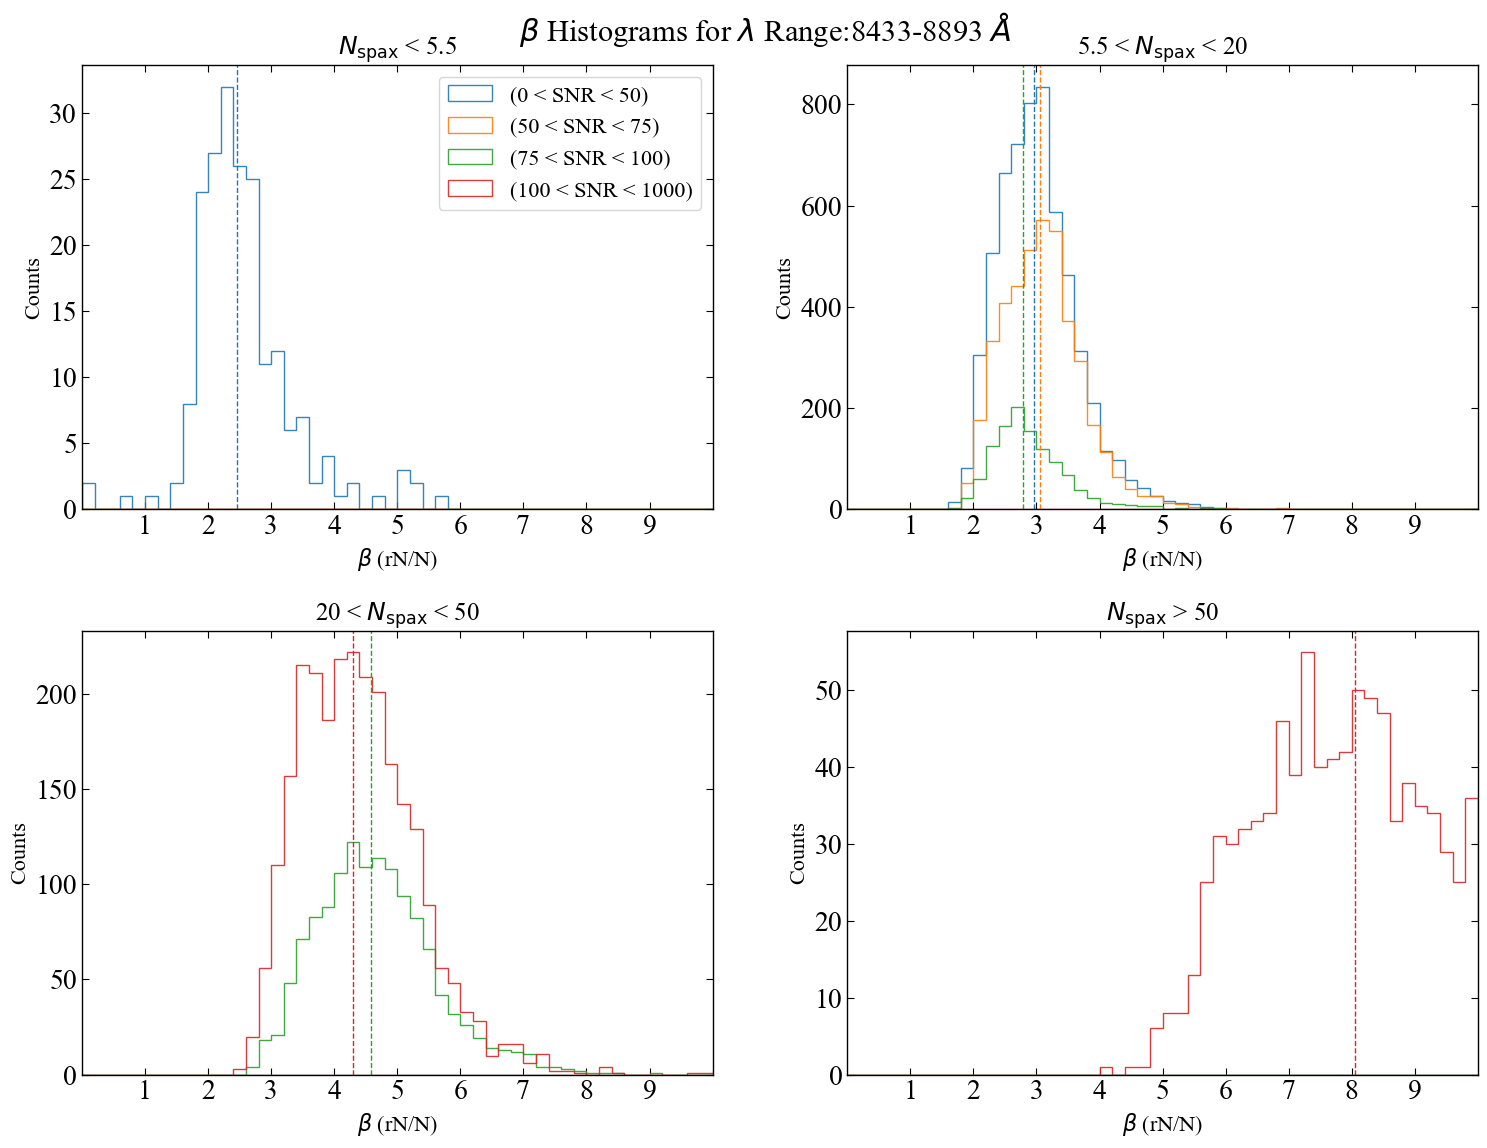

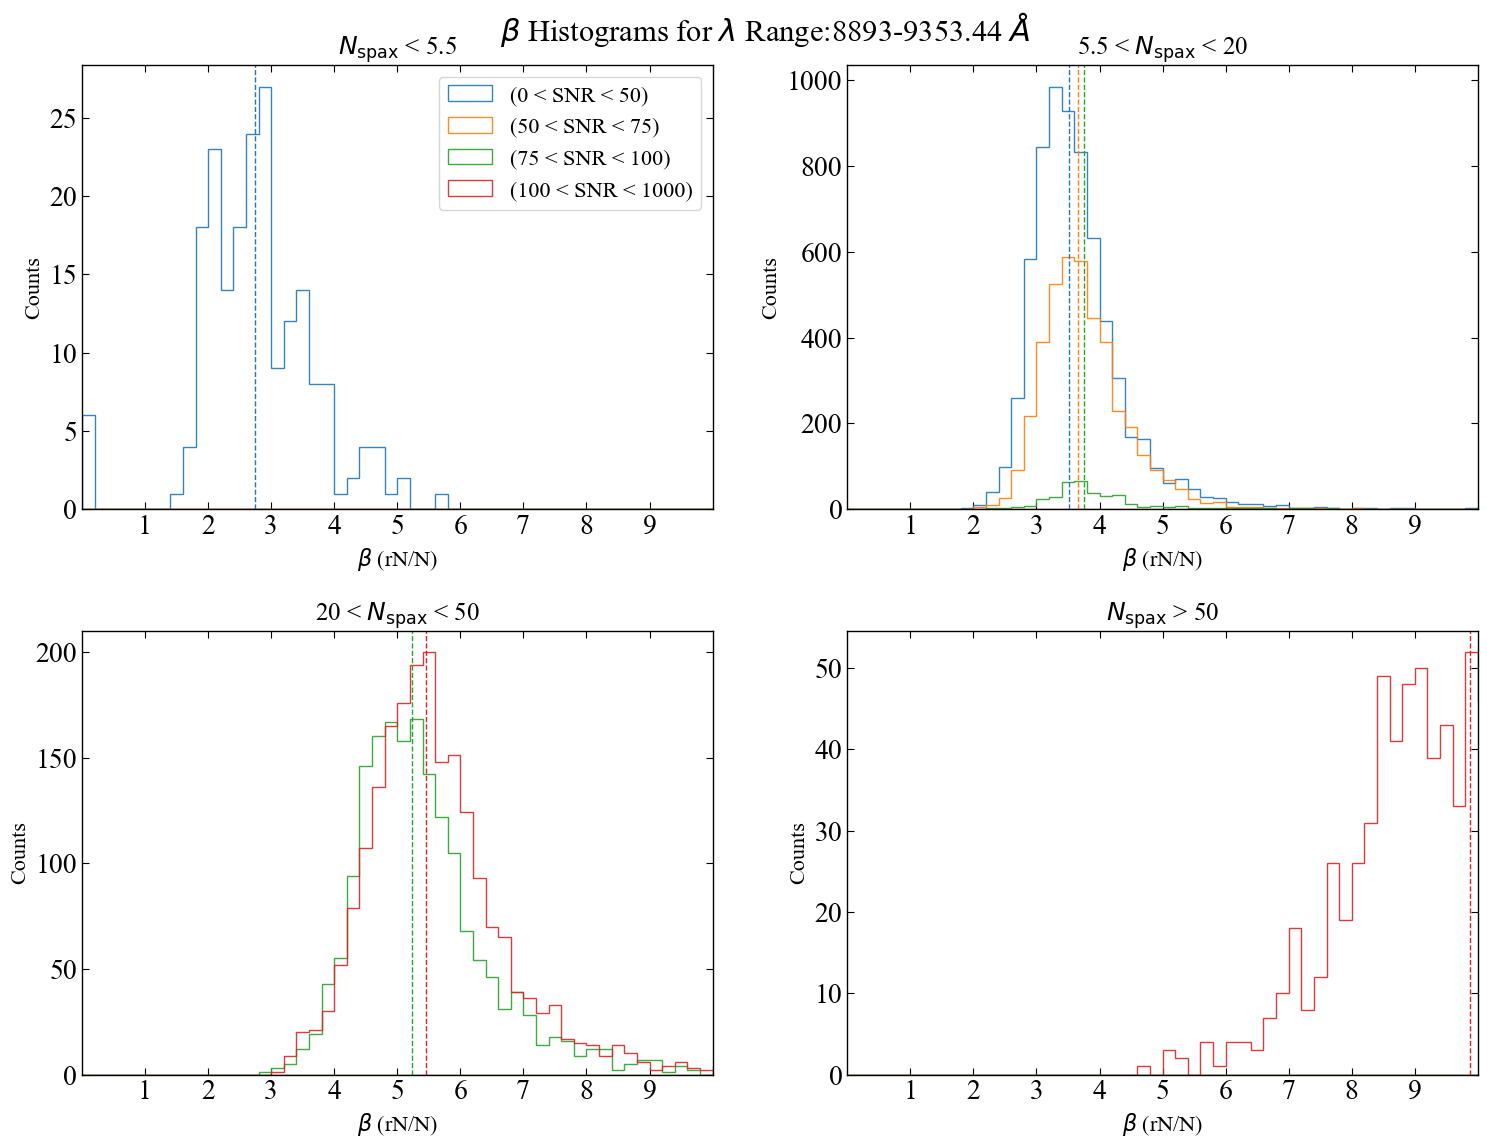

In [131]:
bin_tot0, beta_tot0 = get_betaplots(bin_sort_real0,beta_sort_real0,SNR_sort_real0,wv_lims[0])
bin_tot1, beta_tot1 = get_betaplots(bin_sort_real1,beta_sort_real1,SNR_sort_real1,wv_lims[1])
bin_tot2, beta_tot2 = get_betaplots(bin_sort_real2,beta_sort_real2,SNR_sort_real2,wv_lims[2])
bin_tot3, beta_tot3 = get_betaplots(bin_sort_real3,beta_sort_real3,SNR_sort_real3,wv_lims[3])
bin_tot4, beta_tot4 = get_betaplots(bin_sort_real4,beta_sort_real4,SNR_sort_real4,wv_lims[4])
bin_tot5, beta_tot5 = get_betaplots(bin_sort_real5,beta_sort_real5,SNR_sort_real5,wv_lims[5])
bin_tot6, beta_tot6 = get_betaplots(bin_sort_real6,beta_sort_real6,SNR_sort_real6,wv_lims[6])
bin_tot7, beta_tot7 = get_betaplots(bin_sort_real7,beta_sort_real7,SNR_sort_real7,wv_lims[7])
bin_tot8, beta_tot8 = get_betaplots(bin_sort_real8,beta_sort_real8,SNR_sort_real8,wv_lims[8])
bin_tot9, beta_tot9 = get_betaplots(bin_sort_real9,beta_sort_real9,SNR_sort_real9,wv_lims[9])

In [136]:
N_arr = [3,9,9,9,6]
S_N = [22,70,80,120,5]

def get_beta(N_spx,S_N):
    
    SNR_ranges = np.array([[0,50],[50,75],[75,100],[100,1000]])
    median_beta_hist = [[3,1.3388808  ], [9,1.458873,1.5007526,1.4971246], [25,1.6623335]]
    
    # Quadratic error correction (Sarzi et al. 2018)
    # parameter fits for NGC 4030
    a,b = 0.51, 0.66

    if N_spx == median_beta_hist[0][0]:
        if (S_N >  SNR_ranges[0][0]) & (S_N <  SNR_ranges[0][1]):
            return median_beta_hist[0][1]

        else:
            # beta from Sarzi et al. relation (2018)
            beta = beta_func_quad(N_spx,a,b)
            return beta

    elif N_spx == median_beta_hist[1][0]:

        for k in range(len(SNR_ranges)):
            if (S_N >  SNR_ranges[k][0]) & (S_N <  SNR_ranges[k][1]):
                if k == 3:
                    # beta from Sarzi et al. relation (2018)
                    beta = beta_func_quad(N_spx,a,b)
                    return beta

                else:
                    return median_beta_hist[j][k]

    elif N_spx == median_beta_hist[2][0]:

        if (S_N >  SNR_ranges[2][0]) & (S_N <  SNR_ranges[2][1]):
            return median_beta_hist[2][1]


        else:
            # beta from Sarzi et al. relation (2018)
            beta = beta_func_quad(N_spx,a,b)
            return beta

    else: 
        # beta from Sarzi et al. relation (2018)
        beta = beta_func_quad(N_spx,a,b)
        return beta

In [75]:
N_arr = [3,3,6,9,9,4,25,25,6,9,3]
S_N = [22,70,80,120,5,35,368,88,113,55,32,78]

for i in range(len(N_arr)):
    beta = get_beta(N_arr[i],S_N[i])
    print(N_arr[i],S_N[i],beta)

Using median beta for Nspax size: 3
  using median beta for SNR range: 0 - 50
3 22 1.3388808
Using median beta for Nspax size: 3
  using sarzi relation for S/N: 70
3 70 1.312942941401922
Using sarzi relation for Nspax size: 6
6 80 1.4321877261690499
Using median beta for Nspax size: 9
  using sarzi relation for SNR range: 100 - 1000
9 120 1.4944757039271168
Using median beta for Nspax size: 9
  using median beta for SNR range: 0 - 50
9 5 9
Using sarzi relation for Nspax size: 4
4 35 1.3648651829024145
  using sarzi relation for S/N: 368
25 368 1.6361984531611906
  using median beta for SNR range: 75 - 100
25 88 1.6623335
Using sarzi relation for Nspax size: 6
6 113 1.4321877261690499
Using median beta for Nspax size: 9
  using median beta for SNR range: 50 - 75
9 55 1.458873
Using median beta for Nspax size: 3
  using median beta for SNR range: 0 - 50
3 32 1.3388808


Model Parameter Fits
--------------------
(Garcia+2015) beta(N) = 1 + 0.50*log10(N_spaxel)
(Sarzi+2018)  beta(N) = 1 + 0.51*log10(N_spaxel)^0.66

For Nspax = 25 and SNR_bin > 100
----------------------------------
(Median Beta) beta = 1.77
(Garcia+2015) beta = 1.70
(Sarzi+2018)  beta = 1.64

For Nspax = 100 and SNR_bin > 100
----------------------------------
(Median Beta) beta = 2.49
(Garcia+2015) beta = 2.01
(Sarzi+2018)  beta = 1.81


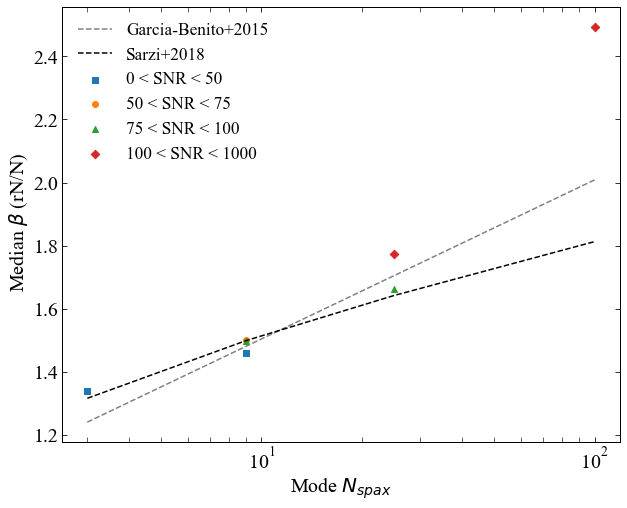

In [12]:
SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]

plt.rcParams['figure.figsize'] = (10,8) 
plt.scatter(bin_less50,beta_less50,label=r'{} < SNR < {}'.format(
                SNR_ranges[0][0],SNR_ranges[0][1]),marker='s')
plt.scatter(bin_50_75,beta_50_75,label=r'{} < SNR < {}'.format(
                SNR_ranges[1][0],SNR_ranges[1][1]),marker='o')       
plt.scatter(bin_75_100,beta_75_100,label=r'{} < SNR < {}'.format(
                SNR_ranges[2][0],SNR_ranges[2][1]),marker='^')
plt.scatter(bin_gr100,beta_gr100,label=r'{} < SNR < {}'.format(
                SNR_ranges[3][0],SNR_ranges[3][1]),marker='D')

bin_all = np.concatenate((bin_less50,bin_50_75,bin_75_100,bin_gr100))
beta_all = np.concatenate((beta_less50,beta_50_75,beta_75_100,beta_gr100))

plt.plot(bin_all,beta_func(bin_all,popt_garcia[0]),c='grey',ls='--',label='Garcia-Benito+2015')
plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')

plt.ylabel(r' Median $\beta$ (rN/N)')
plt.xlabel('Mode $N_{spax}$')
plt.xscale('log')
plt.legend(fontsize='xx-large',frameon=False); 
plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
plt.savefig('/Users/erickaguirre/Desktop/beta_correction_plots/med_beta_vs_Nspax.pdf')

print('Model Parameter Fits')
print('--------------------')
print('(Garcia+2015) beta(N) = 1 + {:.2f}*log10(N_spaxel)'.format(popt_garcia[0]));
print('(Sarzi+2018)  beta(N) = 1 + {:.2f}*log10(N_spaxel)^{:.2f}\n'.format(popt_sarzi[0],popt_sarzi[1]))

print('For Nspax = 25 and SNR_bin > 100')
print('----------------------------------')
print('(Median Beta) beta = {:.2f}'.format(beta_gr100[0]))
print('(Garcia+2015) beta = {:.2f}'.format(beta_func(25,popt_garcia[0])))
print('(Sarzi+2018)  beta = {:.2f}\n'.format(beta_func_quad(25,popt_sarzi[0],popt_sarzi[1])))

print('For Nspax = 100 and SNR_bin > 100')
print('----------------------------------')
print('(Median Beta) beta = {:.2f}'.format(beta_gr100[1]))
print('(Garcia+2015) beta = {:.2f}'.format(beta_func(100,popt_garcia[0])))
print('(Sarzi+2018)  beta = {:.2f}'.format(beta_func_quad(100,popt_sarzi[0],popt_sarzi[1])))

In [43]:
def get_fitted_plot(bin_tot,beta_tot,wv_lim):
    bin_less50 = []
    bin_50_75 = []
    bin_75_100 = []
    bin_gr100 = []

    beta_less50 = []
    beta_50_75 = []
    beta_75_100 = []
    beta_gr100 = []

    for bin_SFR,beta_SFR in zip(bin_tot,beta_tot):
        if len(bin_SFR[0]) == 0:
            bin_less50.append(-999)
            beta_less50.append(-999)
        else:
            bin_less50.append(stats.mode(bin_SFR[0])[0][0])
            beta_less50.append(np.median(beta_SFR[0]))

        if len(bin_SFR[1]) == 0:
            bin_50_75.append(-999)
            beta_50_75.append(-999)
        else:
            bin_50_75.append(stats.mode(bin_SFR[1])[0][0])
            beta_50_75.append(np.median(beta_SFR[1]))

        if len(bin_SFR[2]) == 0:
            bin_75_100.append(-999)
            beta_75_100.append(-999)
        else:
            bin_75_100.append(stats.mode(bin_SFR[2])[0][0])
            beta_75_100.append(np.median(beta_SFR[2]))

        if len(bin_SFR[3]) == 0:
            pass
        else:
            bin_gr100.append(stats.mode(bin_SFR[3])[0][0])
            beta_gr100.append(np.median(beta_SFR[3]))

    bin_less50 = np.array(bin_less50)
    bin_50_75 = np.array(bin_50_75)
    bin_75_100 = np.array(bin_75_100)
    bin_gr100 = np.array(bin_gr100)

    beta_less50 = np.array(beta_less50)
    beta_50_75 = np.array(beta_50_75)
    beta_75_100 = np.array(beta_75_100)
    beta_gr100 = np.array(beta_gr100)

    bin_fit = np.concatenate((bin_less50[bin_less50 > -999],bin_50_75[bin_50_75 > -999],
                              bin_75_100[bin_75_100 > -999]))
    beta_fit = np.concatenate((beta_less50[beta_less50 > -999],beta_50_75[beta_50_75 > -999],
                              beta_75_100[beta_75_100 > -999]))

    # get parameters
    # fit data points usings Sarzi+2018 relationshiop
    popt_sarzi, pcov_sarzi = curve_fit(beta_func_quad, bin_fit, beta_fit)

    SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]

    plt.rcParams['figure.figsize'] = (8,6) 
    fig = plt.figure()
    plt.scatter(bin_less50[bin_less50 > -999],beta_less50[beta_less50 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[0][0],SNR_ranges[0][1]),marker='s')
    plt.scatter(bin_50_75[bin_50_75 > -999],beta_50_75[beta_50_75 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[1][0],SNR_ranges[1][1]),marker='o')       
    plt.scatter(bin_75_100[bin_75_100 > -999],beta_75_100[beta_75_100 > -999],
                    label=r'{} < SNR < {}'.format(SNR_ranges[2][0],SNR_ranges[2][1]),marker='^')
    plt.scatter(bin_gr100,beta_gr100,label=r'{} < SNR < {}'.format(
                    SNR_ranges[3][0],SNR_ranges[3][1]),marker='D')

    bin_all = np.concatenate((bin_less50,bin_50_75,bin_75_100,bin_gr100))
    beta_all = np.concatenate((beta_less50,beta_50_75,beta_75_100,beta_gr100))

    #plt.plot(bin_all,beta_func(bin_all,popt_garcia[0]),c='grey',ls='--',label='Garcia-Benito+2015')
    plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')

    plt.title('Fitted Parameters for $\lambda$ Range:{}-{} $\AA$'.format(
                    wv_lim[0],wv_lim[1]))

    plt.ylabel(r' Median $\beta$ (rN/N)')
    plt.xlabel('Mode $N_{spax}$')
    plt.xscale('log')
    plt.legend(fontsize='x-large',frameon=False); 
    plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
    plt.figtext(x=0.15, y=0.50,s='Parameter Fits\n',fontsize=14)
    text_str = 'a = {:.2f}, b = {:.2f}'.format(popt_sarzi[0],popt_sarzi[1])
    plt.figtext(x=0.15, y=0.49,s=text_str,fontsize=14)
    
    # create data table containting each median beta histogram distribution for a given S/N and N_spax size
    beta_table = Table([beta_less50[:3],beta_50_75[:3],beta_75_100[:3],
                        [popt_sarzi[0],-999,-999],[popt_sarzi[1],-999,-999]],
                  names=('S_N_0-50','S_N_50-75','S_N_75-100','param_fit_a','param_fit_b'))
    table_name =  '/Users/erickaguirre/Desktop/beta_corr_tables/beta_corr_' \
                  + str(wv_lim[0]) +'_' + str(wv_lim[1]) + '.dat'
    beta_table.write(table_name, format='ascii', overwrite=True)  
    
    plt.savefig('/Users/erickaguirre/Desktop/paper_plots/beta_correction_plots/beta_fit_'
                +str(wv_lim[0])+'_'+str(wv_lim[1])+'.pdf');

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bin_less50.append(stats.mode(bin_SFR[0])[0][0])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` 

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bin_less50.append(stats.mode(bin_SFR[0])[0][0])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` 

/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  bin_less50.append(stats.mode(bin_SFR[0])[0][0])
/var/folders/w8/2sm2ctrx0q1_ggrf2bd4lyd40000gn/T/ipykernel_24203/2557953347.py:24: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` 

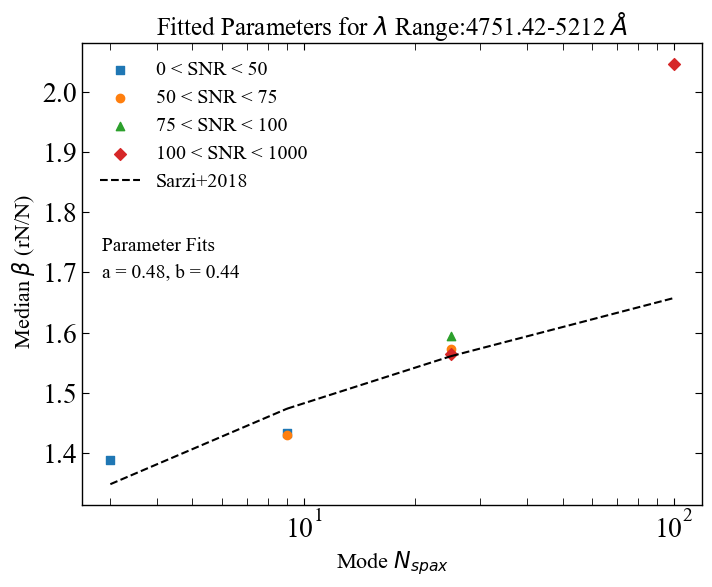

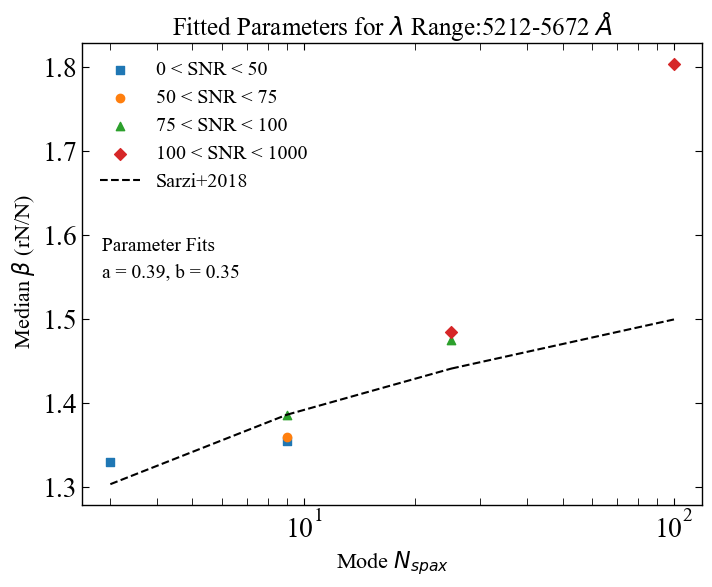

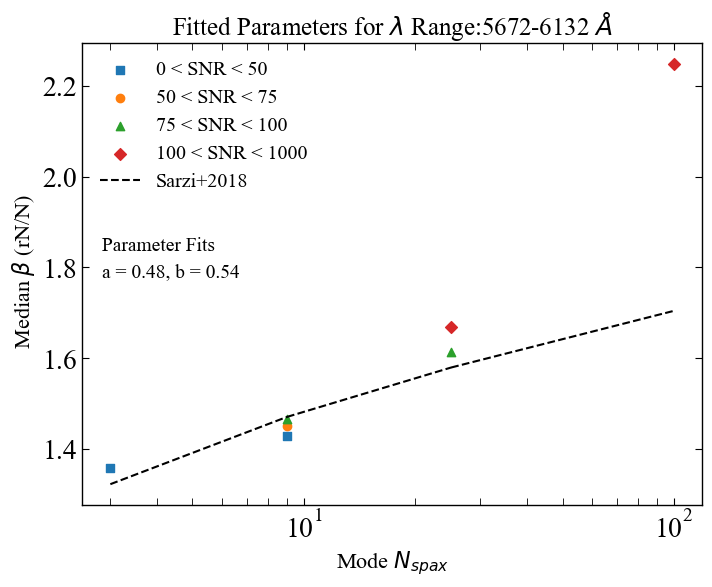

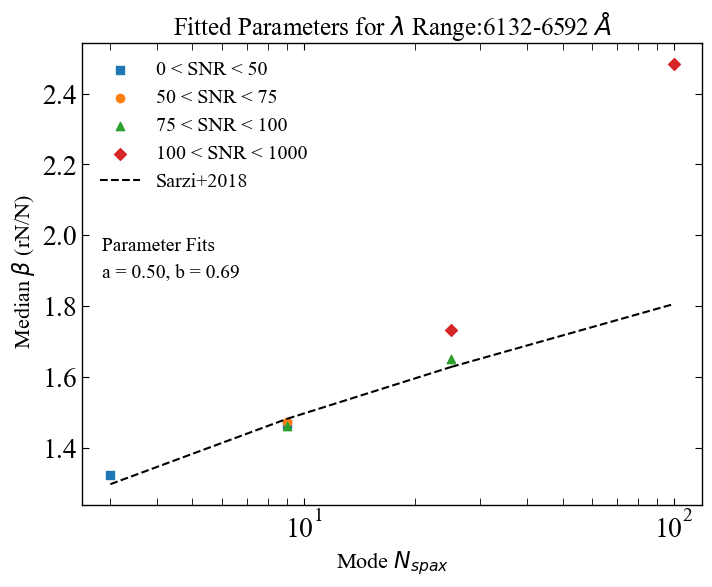

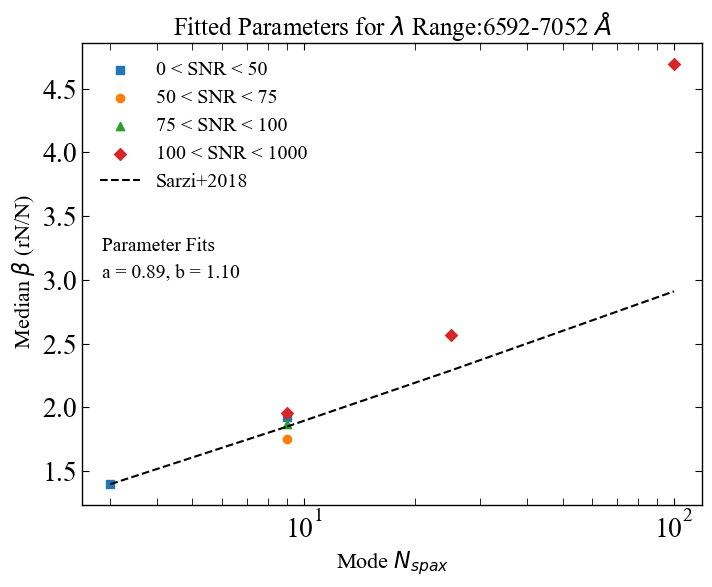

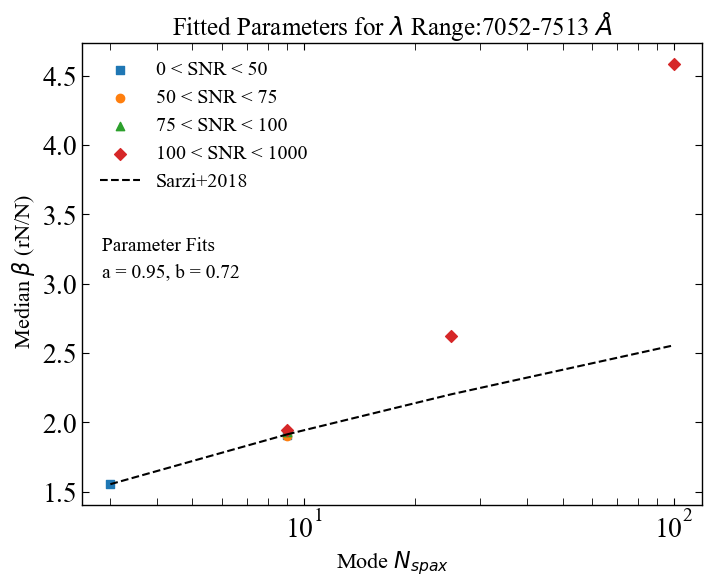

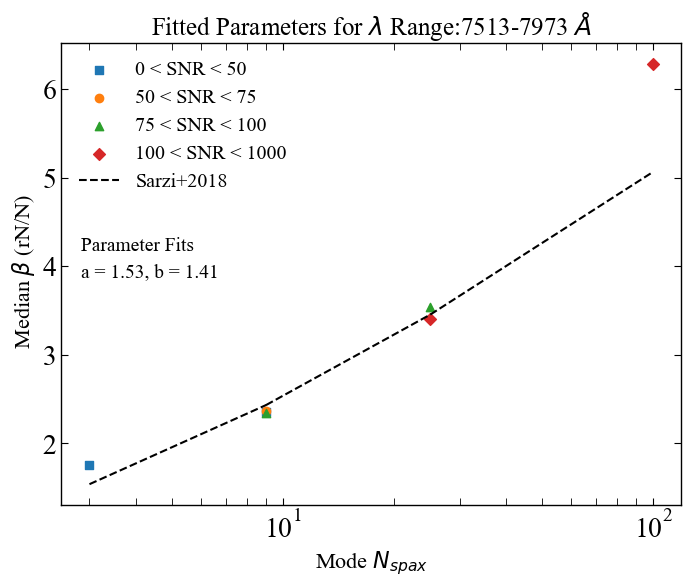

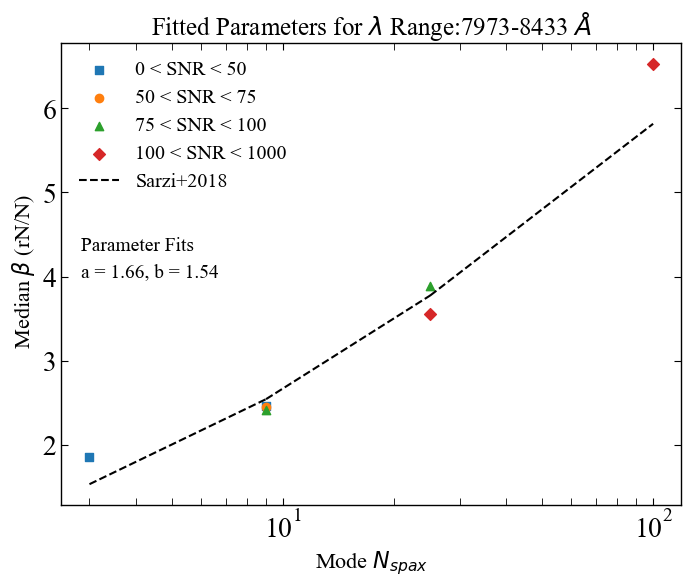

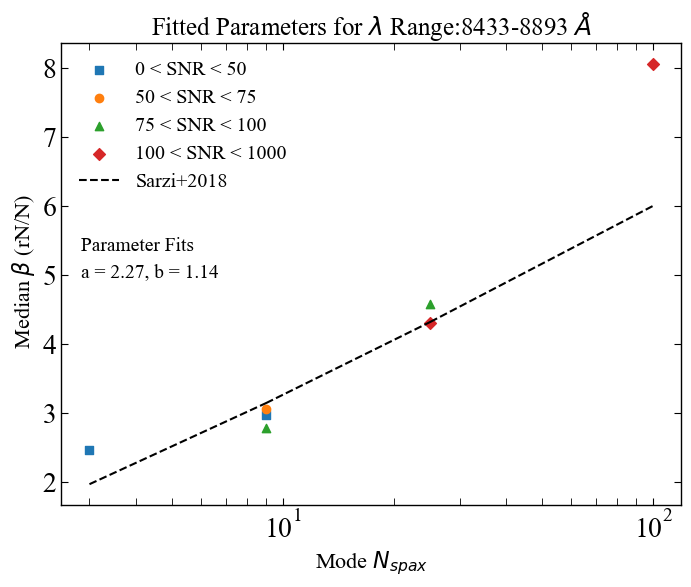

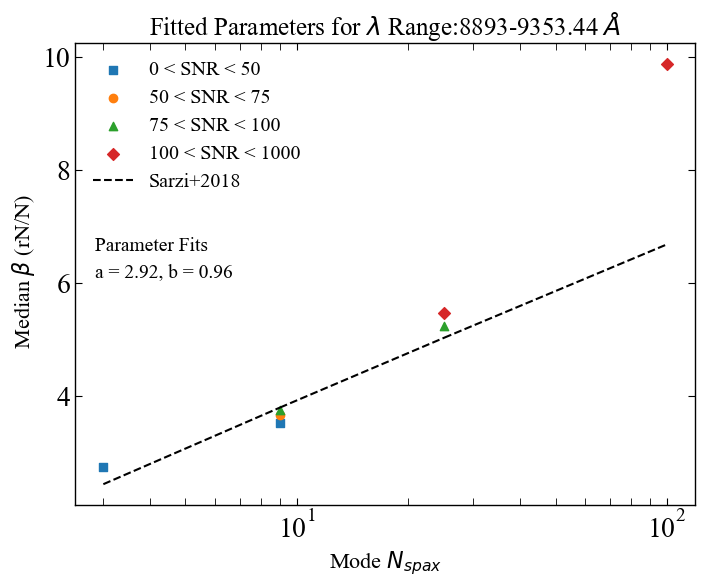

In [44]:
wv_lims = [[4751.42,5212],[5212,5672],[5672,6132],[6132,6592],
           [6592,7052],[7052,7513],[7513,7973],[7973,8433],[8433,8893],[8893,9353.44]]

get_fitted_plot(bin_tot0,beta_tot0,wv_lims[0])
get_fitted_plot(bin_tot1,beta_tot1,wv_lims[1])
get_fitted_plot(bin_tot2,beta_tot2,wv_lims[2])
get_fitted_plot(bin_tot3,beta_tot3,wv_lims[3])
get_fitted_plot(bin_tot4,beta_tot4,wv_lims[4])
get_fitted_plot(bin_tot5,beta_tot5,wv_lims[5])
get_fitted_plot(bin_tot6,beta_tot6,wv_lims[6])
get_fitted_plot(bin_tot7,beta_tot7,wv_lims[7])
get_fitted_plot(bin_tot8,beta_tot8,wv_lims[8])
get_fitted_plot(bin_tot9,beta_tot9,wv_lims[9])

In [15]:
# specificy violin plot colors from plt.violinplot obj
# ex) violinplots = plt.violinplot(x)
def get_violin_colors(violinplot_obj,c_indx):
    colors = ['tab:blue','tab:orange','tab:green','tab:red']
    
    for partname in ('cbars','cmins','cmaxes','cmedians','bodies'):
        violin = violinplot_obj[partname]
        if partname == 'bodies':
            for vp in violin:
                vp.set_color(colors[c_indx])
                vp.set_facecolor(colors[c_indx])
                vp.set_edgecolor(colors[c_indx])
                vp.set_alpha(0.2)
                vp.set_label('uhh')
                
        else:
            violin.set_edgecolor(colors[c_indx])
            violin.set_linewidth(2)

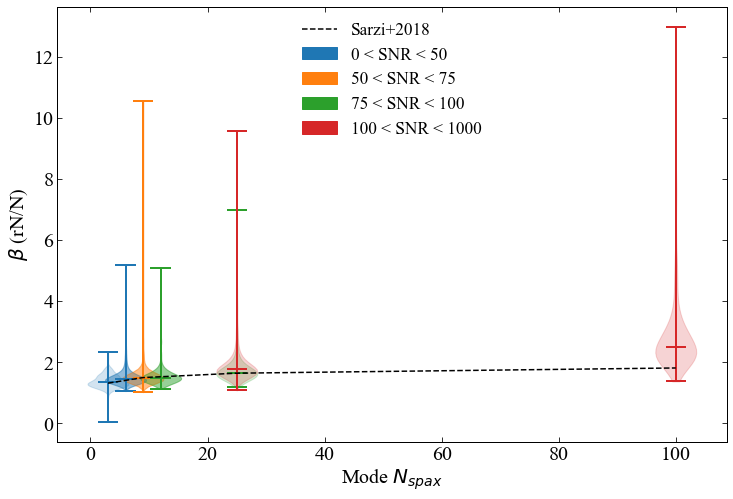

In [38]:
SNR_ranges = [[0,50],[50,75],[75,100],[100,1000]]
bin_uniq = np.unique(bin_all)

x_offset = [-3,0,3]
plt.rcParams['figure.figsize'] = (12,8) 

colors = ['tab:blue','tab:orange','tab:green','tab:red']
for j in range(len(beta_tot)):
    for i in range(len(beta_tot)):
        if len(beta_tot[i][j]) == 0:
            continue
        else:
            if i == 1:
                for k in range(len(beta_tot[i])-1):
                    violinplots = plt.violinplot(beta_tot[i][k],positions=[bin_uniq[i]+x_offset[k]],
                                                 showmedians=True,widths=7)
                    get_violin_colors(violinplots,k)
                continue
            
            else:
                violinplots = plt.violinplot(beta_tot[i][j],positions=[bin_uniq[i]],showmedians=True,
                                             widths=7)
                get_violin_colors(violinplots,j)

plt.plot(bin_all,beta_func_quad(bin_all,popt_sarzi[0],popt_sarzi[1]),c='k',ls='--',label='Sarzi+2018')
plt.tick_params(axis='both', which='both',direction='in',top=True,right=True,length=5)
plt.ylabel(r'$\beta$ (rN/N)')
plt.xlabel('Mode $N_{spax}$');

colors = ['tab:blue','tab:orange','tab:green','tab:red']
color_patches = []
color_patches.append(plt.Line2D([],[],color='k', ls="--",label='Sarzi+2018'))

for i in range(len(SNR_ranges)):
    SNR_str = ('{} < SNR < {}'.format(SNR_ranges[i][0],SNR_ranges[i][1]))
    c_patch = mpatches.Patch(color=colors[i], label= SNR_str)
    color_patches.append(c_patch)
    
plt.legend(handles=color_patches,fontsize='xx-large',loc='upper center',frameon=False)
plt.savefig('/Users/erickaguirre/Desktop/beta_correction_plots/beta_violin_plots.pdf'); 